In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind, chi2_contingency

In [77]:
dtype_dict = {
    'route_id': 'int16',
    'bus_id': 'int32',
    'stop_sequence': 'int16',
    'arrival_delay': 'int16',
    'dwell_time': 'uint16',
    'travel_time_for_previous_section': 'uint16',
    'scheduled_travel_time': 'uint16',
    'upstream_stop_delay': 'int16',
    'origin_delay': 'int16',
    'previous_bus_delay': 'int16',
    'previous_trip_travel_time': 'uint16',
    'traffic_condition': 'float32',
    'recurrent_delay': 'float32'
}

dummy_vars = [
    'factor(weather)Light_Rain', 'factor(weather)Light_Snow', 'factor(weather)Normal',
    'factor(weather)Rain', 'factor(weather)Snow', 'factor(temperature)Cold',
    'factor(temperature)Extra_cold', 'factor(temperature)Normal', 'factor(day_of_week)weekday',
    'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak',
    'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak'
]

for var in dummy_vars:
    dtype_dict[var] = 'uint8'

In [78]:
data_path = 'data/Dataset-PT.csv'

df = pd.read_csv(
    data_path,
    dtype=dtype_dict,
    parse_dates=['Calendar_date'],
    date_format='%Y%m%d'
)

numeric_cols = [
    'arrival_delay', 'dwell_time', 'travel_time_for_previous_section',
    'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay',
    'previous_bus_delay', 'previous_trip_travel_time', 'traffic_condition',
    'recurrent_delay'
]

categorical_columns = ['weather', 'temperature', 'day_of_week', 'time_of_day']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Validation of dummy variables
for var in dummy_vars:
    if not df[var].isin([0, 1]).all():
        raise ValueError(f"The variable {var} contains values other than 0 and 1")

In [79]:
df.insert(1, 'day_of_week_num', df['Calendar_date'].dt.dayofweek)

# Calculate Statistics
## Continuous Variables

In [80]:
def calculate_continuous_statistics(df, cols):
    # Create a dictionary to store results
    stats_dict = {
        'Variable': [],
        'Mean': [],
        'Median': [],
        'Standard Deviation': [],
        '95th Percentile': [],
        'Maximum': []
    }

    # Calculate statistics for each column
    for col in cols:
        stats_dict['Variable'].append(col)
        stats_dict['Mean'].append(df[col].mean())
        stats_dict['Median'].append(df[col].median())
        stats_dict['Standard Deviation'].append(df[col].std())
        stats_dict['95th Percentile'].append(df[col].quantile(0.95))
        stats_dict['Maximum'].append(df[col].max())

    # Convert the dictionary to a DataFrame
    stats_df = pd.DataFrame(stats_dict)

    # Print the table in markdown format
    print("\n### Descriptive Statistics for Continuous Variables ###\n")
    print(stats_df.to_markdown(index=False))

    return stats_df


# Calculate descriptive statistics for continuous variables
continuous_stats = calculate_continuous_statistics(df, numeric_cols)


### Descriptive Statistics for Continuous Variables ###

| Variable                         |     Mean |   Median |   Standard Deviation |   95th Percentile |   Maximum |
|:---------------------------------|---------:|---------:|---------------------:|------------------:|----------:|
| arrival_delay                    | 134.972  |  88      |             193.899  |           513     |  2257     |
| dwell_time                       |  31.9947 |  25      |              27.2157 |            80     |  1616     |
| travel_time_for_previous_section |  71.441  |  64      |              37.5906 |           137     |  1069     |
| scheduled_travel_time            | 105.918  | 104      |              36.421  |           180     |   198     |
| upstream_stop_delay              | 135.652  |  86      |             190.272  |           510     |  2257     |
| origin_delay                     |  75.1072 |  27      |             133.626  |           354     |  1812     |
| previous_bus_delay          

## Categorical Variables

In [81]:
def calculate_categorical_frequencies(df, cols):
    print("\n### Absolute and Relative Frequencies for Categorical Variables ###\n")

    # Iterate over categorical columns to calculate frequencies
    for col in cols:
        absolute_freq = df[col].value_counts()
        relative_freq = df[col].value_counts(normalize=True) * 100

        # Combine absolute and relative frequencies into a single DataFrame
        freq_df = pd.DataFrame({
            'Absolute Frequency': absolute_freq,
            'Relative Frequency (%)': relative_freq
        }).reset_index().rename(columns={'index': col})

        # Print the table in markdown format
        print(f"\nFrequencies for {col}:\n")
        print(freq_df.to_markdown(index=False))


# Apply the function to all categorical variables
categorical_vars = ['weather', 'temperature', 'day_of_week', 'time_of_day']
calculate_categorical_frequencies(df, categorical_vars)


### Absolute and Relative Frequencies for Categorical Variables ###


Frequencies for weather:

| weather    |   Absolute Frequency |   Relative Frequency (%) |
|:-----------|---------------------:|-------------------------:|
| Normal     |               514971 |                94.4722   |
| Light Rain |                13338 |                 2.44688  |
| Light Snow |                 9720 |                 1.78315  |
| Snow       |                 3699 |                 0.678587 |
| Rain       |                 3375 |                 0.619149 |

Frequencies for temperature:

| temperature   |   Absolute Frequency |   Relative Frequency (%) |
|:--------------|---------------------:|-------------------------:|
| Normal        |               473877 |                 86.9335  |
| Cold          |                61452 |                 11.2735  |
| Extra cold    |                 9774 |                  1.79306 |

Frequencies for day_of_week:

| day_of_week   |   Absolute Frequency |   Rel

## Continuous Variables by Day of the Week

In [82]:
def calculate_statistics_by_day_of_week(df, cols):
    # Group by day_of_week_num (0=Monday, ..., 6=Sunday) and calculate statistics
    grouped_stats = df.groupby('day_of_week_num')[cols].agg(['mean', 'std']).reset_index()

    # Return the DataFrame with grouped statistics
    return grouped_stats


# Calculate aggregated statistics by day of the week excluding certain variables
continuous_stats_by_day = calculate_statistics_by_day_of_week(df, numeric_cols)

In [83]:
continuous_stats_by_day

day_of_week_num arrival_delay             dwell_time             \
                           mean         std       mean        std   
0               0     93.867388  154.355705  32.849864  27.124447   
1               1    113.019164  167.005684  33.440333  27.439173   
2               2    122.947733  191.527009  33.279306  27.225144   
3               3    130.577944  197.876176  33.061258  28.177965   
4               4    122.213895  198.946633  32.558489  27.491967   
5               5    194.119135  208.720187  28.880151  26.156917   
6               6    205.849989  224.513593  27.646395  25.585048   

  travel_time_for_previous_section            scheduled_travel_time  \
                              mean        std                  mean   
0                        72.206555  37.870704            108.934327   
1                        73.049012  37.521046            109.447646   
2                        73.176239  37.952212            109.336312   
3                        73.053964  38.188898            108.791956   
4                        72.883098  39.984010            108.753603   
5                        67.177042  34.657081             95.944980   
6                        65.567901  34.610090             93.834100   

             upstream_stop_delay  ... origin_delay              \
         std                mean  ...         mean         std   
0  37.056137           95.863022  ...    55.197125   96.328258   
1  37.140586          114.143172  ...    62.584471  108.913283   
2  37.119745          123.998703  ...    70.189765  143.306812   
3  37.023508          131.410663  ...    73.910807  140.739235   
4  36.914853          123.697759  ...    68.628502  123.008642   
5  32.169477          192.317628  ...    97.029743  148.314201   
6  31.292566          204.840912  ...   118.308679  170.067860   

  previous_bus_delay             previous_trip_travel_time              \
                mean         std                      mean         std   
0          93.532564  157.852768                 74.038788   36.169649   
1         113.203485  166.610019                 74.817713   35.353487   
2         122.347999  191.470426                 74.936091   35.742338   
3         128.663146  193.383090                 74.824520   36.064721   
4         122.394199  199.092044                 74.637316   37.955645   
5         193.359935  209.251055                 73.712263  565.744234   
6         204.709931  224.623913                 67.150267   33.272113   

  traffic_condition            recurrent_delay             
               mean        std            mean        std  
0         74.045441  32.538769       73.475121  29.664040  
1         74.787613  31.968313       73.831070  29.609947  
2         74.928986  32.326237       74.113617  29.700743  
3         74.797745  32.478577       74.841293  30.017424  
4         74.607124  34.522602       74.443680  29.853054  
5         68.755112  30.261444       68.866676  28.693089  
6         67.093437  30.232542       66.847786  28.114079  

[7 rows x 21 columns]

## Continuous Variables by Stop Sequence

In [84]:
def calculate_grouped_statistics(df, group_by_col, continuous_cols):
    grouped_stats = df.groupby(group_by_col)[continuous_cols].agg(['mean', 'median', 'std'])
    print(f"\n### Aggregated Statistics by {group_by_col} ###\n")
    return grouped_stats


# Aggregated statistics by stop_sequence
stats_by_stop = calculate_grouped_statistics(df, 'stop_sequence', numeric_cols)


### Aggregated Statistics by stop_sequence ###



In [85]:
stats_by_stop

arrival_delay                    dwell_time                    \
                       mean median         std       mean median        std   
stop_sequence                                                                 
1                 63.961117   22.0  145.566785   0.402546    0.0  11.353929   
2                100.140274   60.0  150.182380  64.577096   59.0  30.563797   
3                 92.829660   54.0  152.244160  20.506167   20.0  14.309873   
4                 65.273961   29.0  157.159572  29.624598   27.0  13.692514   
5                107.407251   65.0  156.259919  49.767646   43.0  25.926348   
6                138.431671   97.0  160.266349  30.047452   28.0  13.814121   
7                128.251226   88.0  164.838097  24.786765   24.0  11.707203   
8                106.233593   68.0  171.644522  23.099064   22.0  10.800178   
9                136.354797   93.0  171.465535  57.596067   53.0  26.178499   
10               161.177473  119.0  176.470361  32.704493   30.0  17.201352   
11               130.101887   88.0  179.896872  23.570657   22.0  10.411150   
12                89.425182   49.0  182.069784  24.740948   24.0  11.407295   
13               154.455347  105.0  179.442006  74.981871   70.0  49.223641   
14               147.551092  100.0  187.018197  41.276586   37.0  19.500351   
15               155.664223  110.0  192.758800  42.400168   41.0  18.643796   
16               127.777007   85.0  200.912381  26.271187   24.0  16.117105   
17               179.752439  132.0  197.402577  71.405815   60.0  43.079986   
18               208.634504  162.0  202.633034  31.493833   27.0  18.200726   
19               208.887761  162.0  205.533794  28.829313   27.0  18.320123   
20               178.565209  133.0  209.287971  29.793303   25.0  20.720706   
21               170.589777  123.0  210.290436  36.174253   31.0  19.064053   
22               160.839764  113.0  213.719941  15.378325   16.0  11.925414   
23               156.035366  110.0  216.145907  14.830601   15.0   9.838297   
24               132.272277   88.0  220.344312  17.113478   17.0   9.873198   
25               146.122393  101.0  222.181308  28.223339   23.0  16.901171   
26               140.759126   97.0  225.188212  11.404428   14.0   8.788070   
27                56.756055   16.0  230.093371  12.855961   15.0   9.844967   

              travel_time_for_previous_section                    \
                                          mean median        std   
stop_sequence                                                      
1                                     0.000000    0.0   0.000000   
2                                   159.178959  149.0  42.172272   
3                                    50.290208   48.0  10.416896   
4                                    44.216207   41.0  10.283314   
5                                   106.851157  100.0  27.207203   
6                                   113.090990  110.0  22.673252   
7                                    53.238249   51.0  16.307714   
8                                    76.197632   74.0  14.398180   
9                                    89.965080   87.0  24.391595   
10                                   40.411164   37.0  11.966426   
11                                  113.120610  110.0  17.681745   
12                                   77.146070   71.0  21.192732   
13                                   44.538065   39.0  15.393913   
14                                   88.021002   87.0  23.262570   
15                                   96.844024   94.0  19.763329   
16                                   55.059290   53.0  11.312977   
17                                  110.318738  105.0  27.350711   
18                                   77.236416   71.0  27.976403   
19                                   87.583238   88.0  29.960161   
20                                   43.487444   41.0  13.868263   
21                                   55.137847   50.0  16.281287   
22         

## Categorical Variables by Day of the Week

In [86]:
def calculate_categorical_frequencies_by_group(df, group_by_col, categorical_cols):
    combined_freq_dict = {}

    # Calculate frequencies for each categorical variable by the specified group
    for col in categorical_cols:
        # Absolute frequency by group
        abs_freq = df.groupby(group_by_col)[col].value_counts().unstack().fillna(0)

        # Relative frequency by group (proportion)
        rel_freq = abs_freq.div(abs_freq.sum(axis=1), axis=0) * 100

        # Combine absolute and relative frequencies into a single DataFrame
        combined_freq = pd.concat([rel_freq], axis=1, keys=['(%)'])

        # Rearrange columns so that relative frequencies are next to absolute frequencies
        combined_freq.columns = [f'{lvl1}_{lvl2}' for lvl1, lvl2 in combined_freq.columns]

        combined_freq_dict[col] = combined_freq

    return combined_freq_dict


# Define the categorical variables for analysis
categorical_vars = ['weather', 'temperature', 'day_of_week', 'time_of_day']

# Calculate frequencies for categorical variables by day of the week
frequencies_by_day = calculate_categorical_frequencies_by_group(df, 'day_of_week_num', categorical_vars)

# Display results for a categorical variable as an example
for col, freqs in frequencies_by_day.items():
    print(f"\n### Combined Frequencies for {col} ###\n")
    print(freqs)


### Combined Frequencies for weather ###

                 (%)_Light Rain  (%)_Light Snow  (%)_Normal  (%)_Rain  \
day_of_week_num                                                         
0                      4.472843        1.277955   92.939297  0.000000   
1                      0.758265        1.273885   97.088262  0.000000   
2                      0.700579        1.644837   96.466646  1.187938   
3                      2.246094        2.213542   94.986979  0.195312   
4                      3.320650        1.418194   93.497060  0.691802   
5                      5.024116        2.572347   88.987138  2.411576   
6                      0.788955        2.514793   96.696252  0.000000   

                 (%)_Snow  
day_of_week_num            
0                1.309904  
1                0.879588  
2                0.000000  
3                0.358073  
4                1.072293  
5                1.004823  
6                0.000000  

### Combined Frequencies for temperature ###



## Categorical Variables by Stop Sequence

In [87]:
def calculate_categorical_frequencies_by_stop_sequence(df, categorical_cols):
    combined_freq_dict = {}

    # Calculate frequencies for each categorical variable by stop_sequence
    for col in categorical_cols:
        # Absolute frequency by group (stop_sequence)
        abs_freq = df.groupby('stop_sequence')[col].value_counts().unstack().fillna(0)

        # Relative frequency by group (proportion)
        rel_freq = abs_freq.div(abs_freq.sum(axis=1), axis=0) * 100

        # Create DataFrame with only relative frequencies
        combined_freq = pd.concat([rel_freq], axis=1, keys=['(%)'])

        # Rename columns to reflect categories
        combined_freq.columns = [f'{lvl1}_{lvl2}' for lvl1, lvl2 in combined_freq.columns]

        combined_freq_dict[col] = combined_freq

    return combined_freq_dict

# Calculate relative frequencies for categorical variables by stop_sequence

In [88]:
frequencies_by_stop_sequence = calculate_categorical_frequencies_by_stop_sequence(df, categorical_vars)

# Display results for a categorical variable as an example
for col, freqs in frequencies_by_stop_sequence.items():
    print(f"\n### Relative Frequencies for {col} by stop_sequence ###\n")
    print(freqs)

# Plots Mean and Standard Deviation
## Continuous Variables vs. Day of the Week
exclude_vars = ['travel_time_for_previous_section', 'scheduled_travel_time', 'origin_delay']

# Filter numeric variables excluding the specified ones
numeric_cols_filtered = [col for col in numeric_cols if col not in exclude_vars]


def calculate_and_plot_by_day(df, cols, group_by_col='day_of_week_num', exclude=None):
    # Exclude variables if the exclude list is provided
    if exclude is not None:
        cols = [col for col in cols if col not in exclude]

    # Group by day_of_week_num and calculate statistics
    grouped_stats = df.groupby(group_by_col)[cols].agg(['mean', 'std']).reset_index()

    # Calculate the number of rows needed for the grid (2 columns)
    num_cols = 2
    num_rows = (len(cols) + 1) // num_cols

    # Set up the figure size
    plt.figure(figsize=(15, num_rows * 5))

    # Plot each continuous variable
    for i, col in enumerate(cols, 1):
        plt.subplot(num_rows, num_cols, i)

        # Extract mean and standard deviation
        x = grouped_stats[group_by_col]
        y_mean = grouped_stats[(col, 'mean')]
        y_std = grouped_stats[(col, 'std')]

        # Plot mean and standard deviation band
        plt.plot(x, y_mean, label='Mean', color='blue', marker='o')
        plt.fill_between(x, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.2, label='Standard Deviation')

        # Customize the plot
        plt.title(f'Mean and Standard Deviation of {col} by {group_by_col}')
        plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
        plt.ylabel(col.capitalize())
        plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])  # Day labels
        plt.legend()
        plt.grid(True)

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()

    # Return grouped statistics
    return grouped_stats



### Relative Frequencies for weather by stop_sequence ###

               (%)_Light Rain  (%)_Light Snow  (%)_Normal  (%)_Rain  (%)_Snow
stop_sequence                                                                
1                    2.446877        1.783149   94.472237  0.619149  0.678587
2                    2.446877        1.783149   94.472237  0.619149  0.678587
3                    2.446877        1.783149   94.472237  0.619149  0.678587
4                    2.446877        1.783149   94.472237  0.619149  0.678587
5                    2.446877        1.783149   94.472237  0.619149  0.678587
6                    2.446877        1.783149   94.472237  0.619149  0.678587
7                    2.446877        1.783149   94.472237  0.619149  0.678587
8                    2.446877        1.783149   94.472237  0.619149  0.678587
9                    2.446877        1.783149   94.472237  0.619149  0.678587
10                   2.446877        1.783149   94.472237  0.619149  0.678587
11  

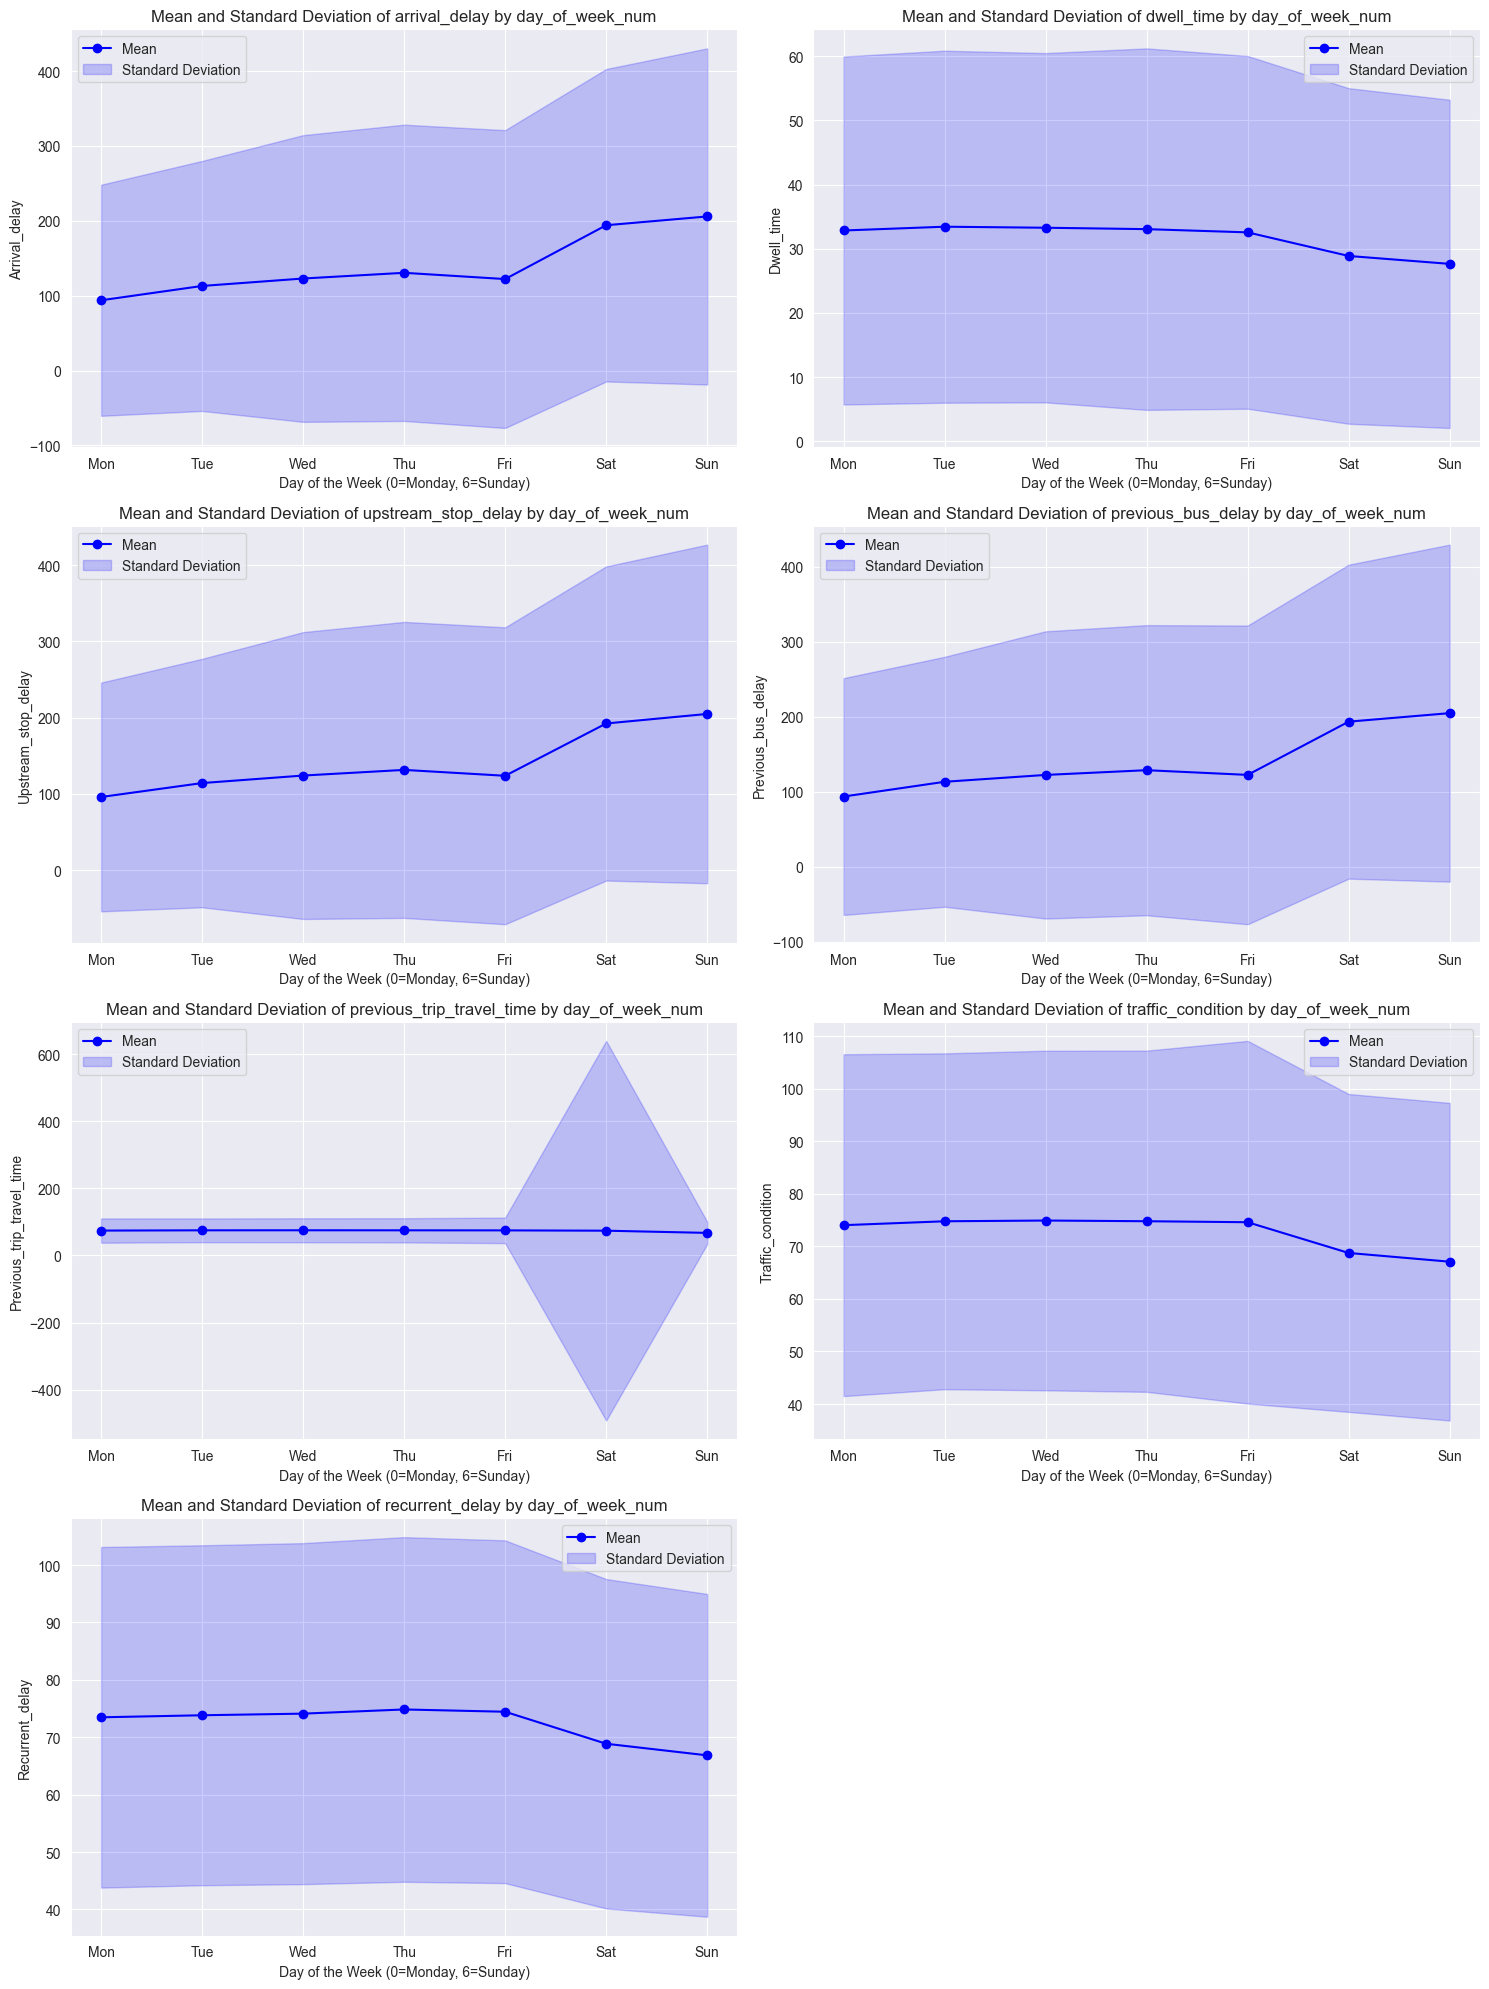

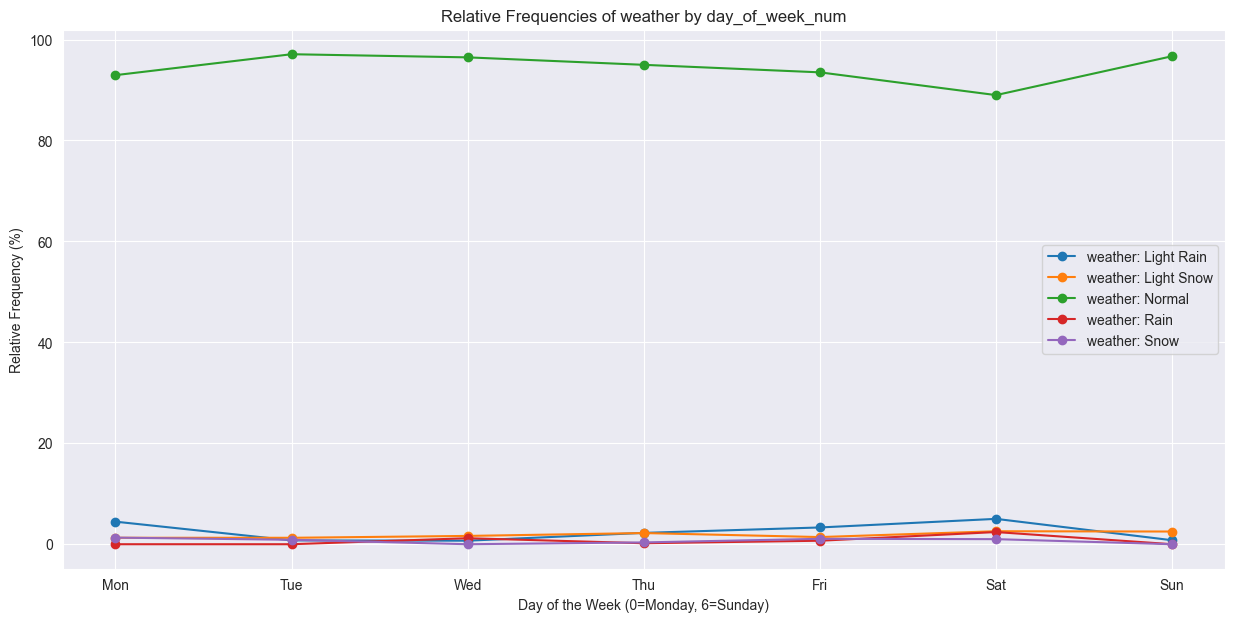

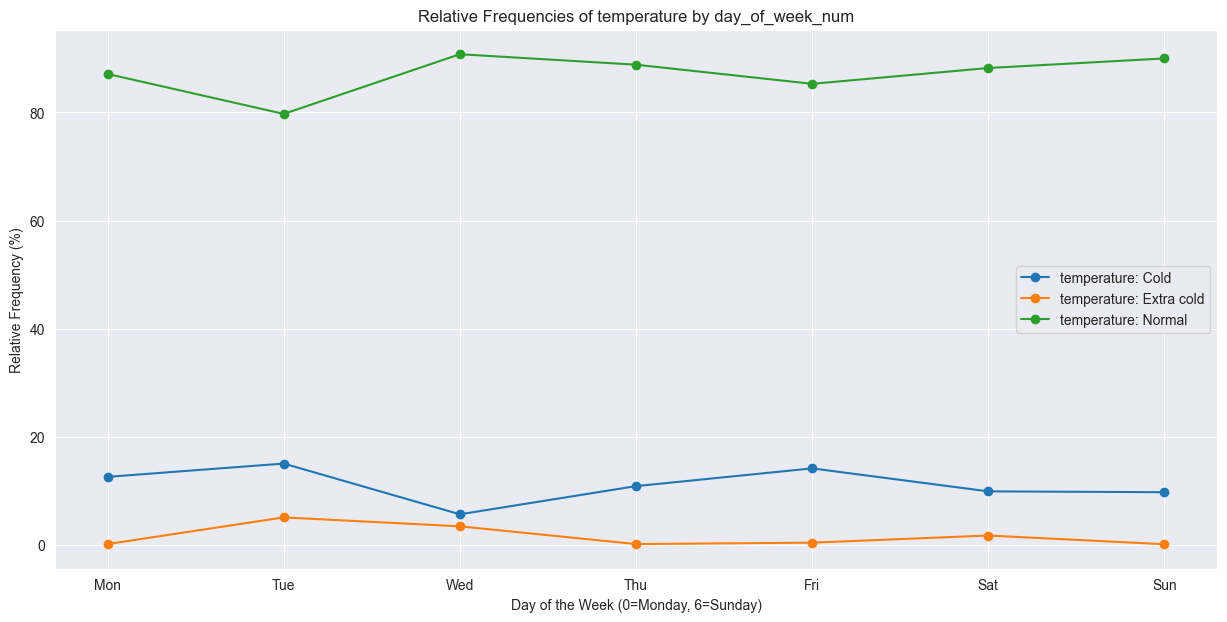

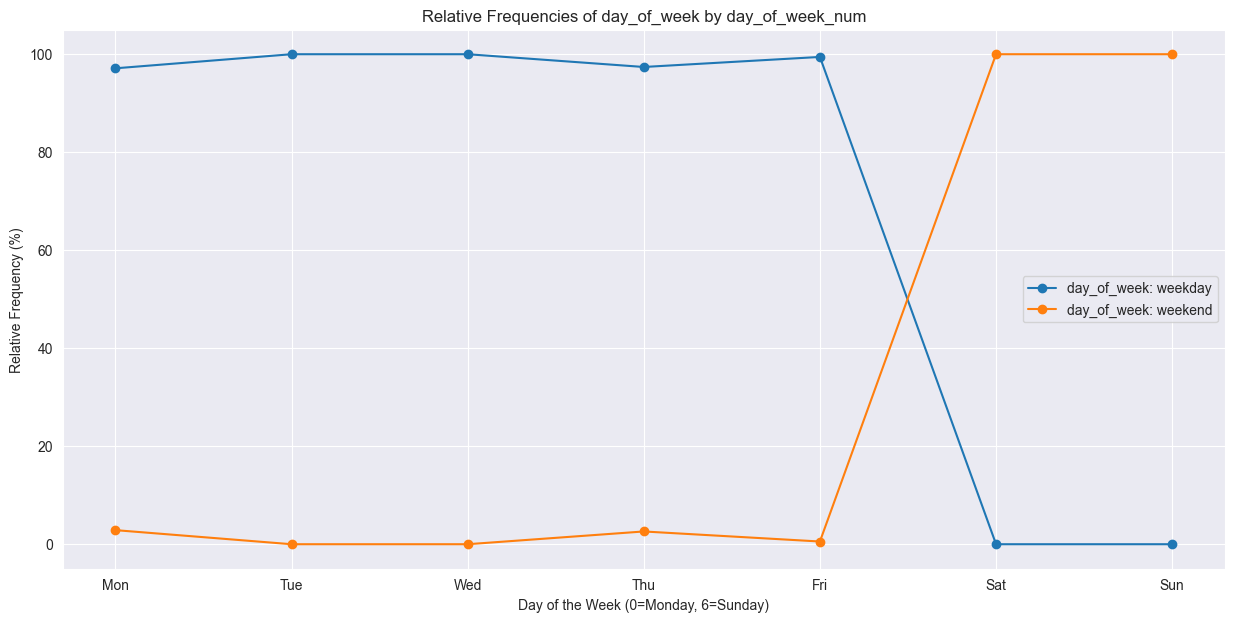

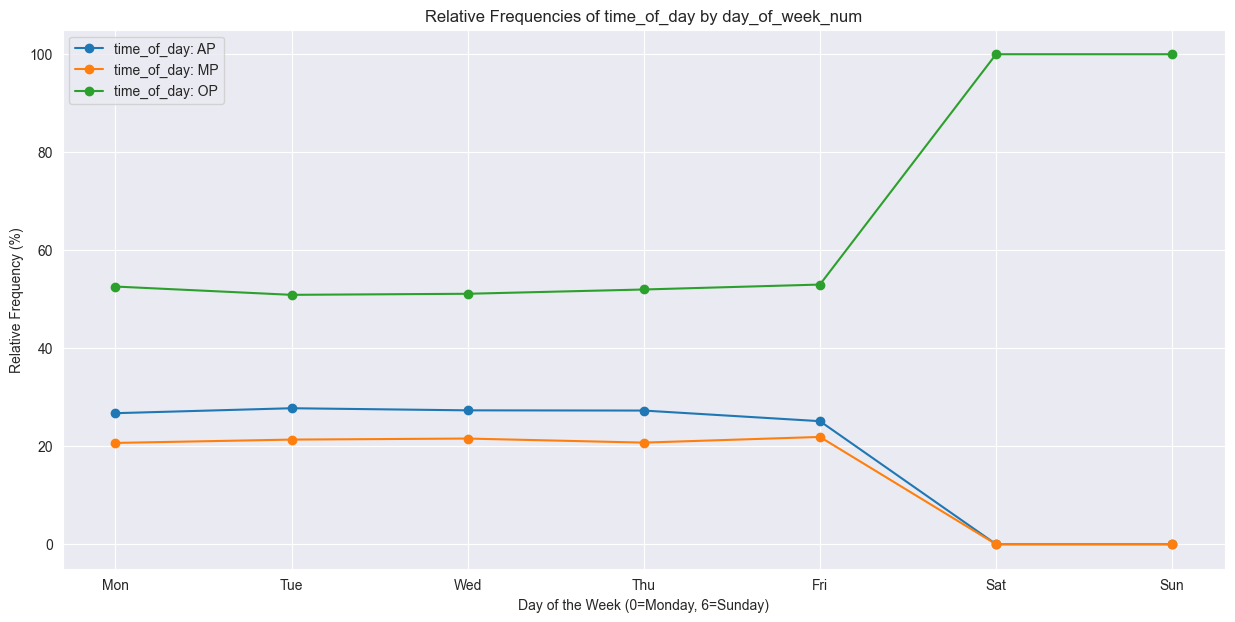

In [89]:
# Apply the function to calculate and plot statistics by day of the week excluding certain variables
stats_by_day = calculate_and_plot_by_day(df, numeric_cols, exclude=exclude_vars)
## Categorical Variables vs. Stop Sequence
exclude_categorical_vars = ['day_of_week']


def plot_categorical_frequencies_by_day(df, categorical_cols, group_by_col='day_of_week_num'):
    # Calculate relative frequencies by group (day of the week)
    for col in categorical_cols:
        # Calculate absolute and then relative frequencies
        abs_freq = df.groupby(group_by_col)[col].value_counts().unstack().fillna(0)
        rel_freq = abs_freq.div(abs_freq.sum(axis=1), axis=0) * 100

        # Set up the figure size
        plt.figure(figsize=(15, 7))

        # Create plot for each categorical variable
        for category in rel_freq.columns:
            plt.plot(rel_freq.index, rel_freq[category], marker='o', label=f'{col}: {category}')

        # Customize the plot
        plt.title(f'Relative Frequencies of {col} by {group_by_col}')
        plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
        plt.ylabel('Relative Frequency (%)')
        plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])  # Day labels
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.show()


# Plot relative frequencies of categorical variables by day of the week
plot_categorical_frequencies_by_day(df, categorical_columns)
## Categorical Variables vs. Stop Sequence
exclude_categorical_vars = ['day_of_week']

# Filter categorical variables excluding the specified ones
categorical_vars_filtered = [col for col in categorical_vars if col not in exclude_categorical_vars]


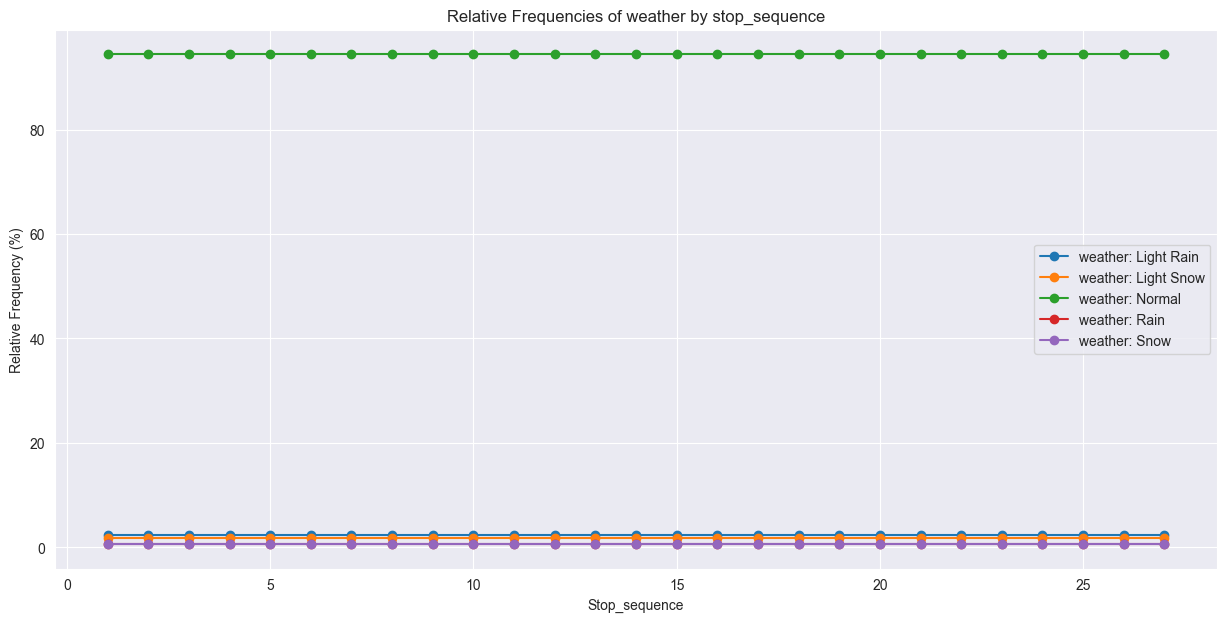

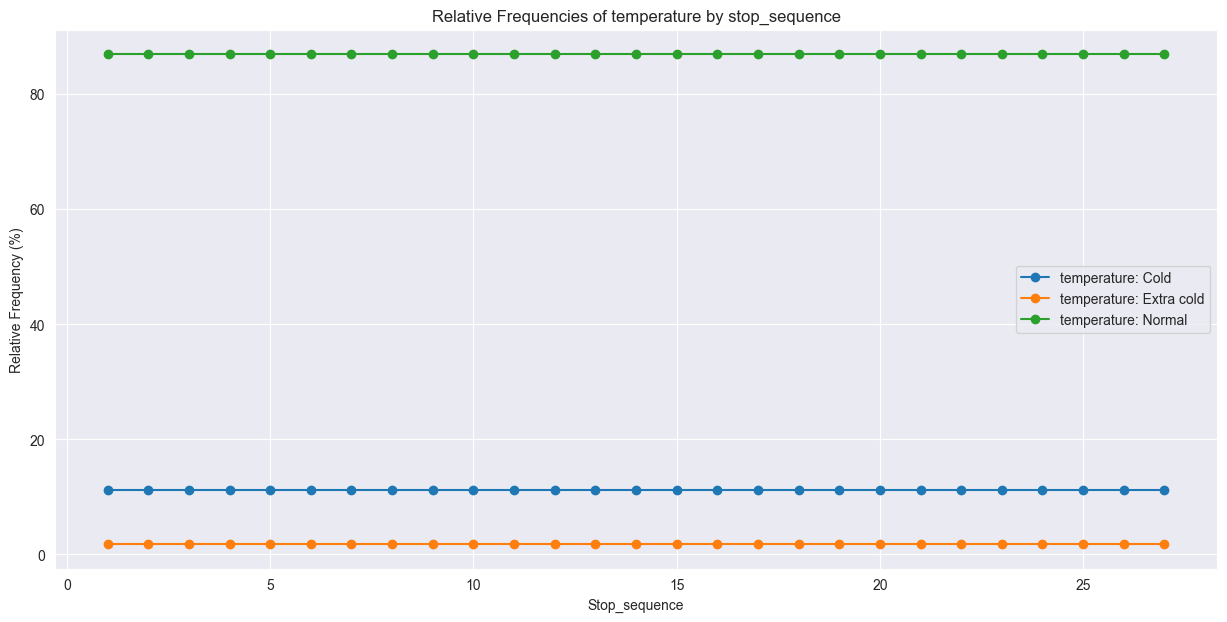

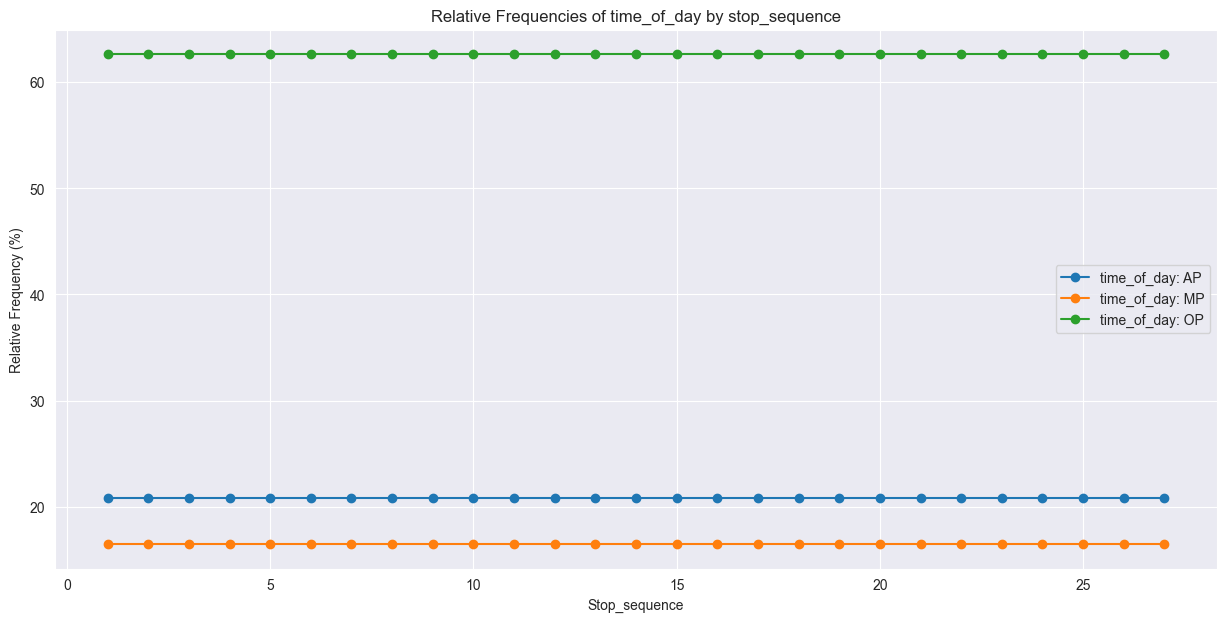

In [90]:
def plot_categorical_frequencies_by_stop_sequence(df, categorical_cols, group_by_col='stop_sequence'):
    # Calculate relative frequencies by group (stop_sequence)
    for col in categorical_cols:
        # Calculate absolute and then relative frequencies
        abs_freq = df.groupby(group_by_col)[col].value_counts().unstack().fillna(0)
        rel_freq = abs_freq.div(abs_freq.sum(axis=1), axis=0) * 100

        # Set up the figure size
        plt.figure(figsize=(15, 7))

        # Create plot for each categorical variable
        for category in rel_freq.columns:
            plt.plot(rel_freq.index, rel_freq[category], marker='o', label=f'{col}: {category}')

        # Customize the plot
        plt.title(f'Relative Frequencies of {col} by {group_by_col}')
        plt.xlabel(group_by_col.capitalize())
        plt.ylabel('Relative Frequency (%)')
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.show()


# Plot relative frequencies of categorical variables by stop_sequence
plot_categorical_frequencies_by_stop_sequence(df, categorical_vars_filtered)

# Histogram Plots
## Histograms of Continuous Variables

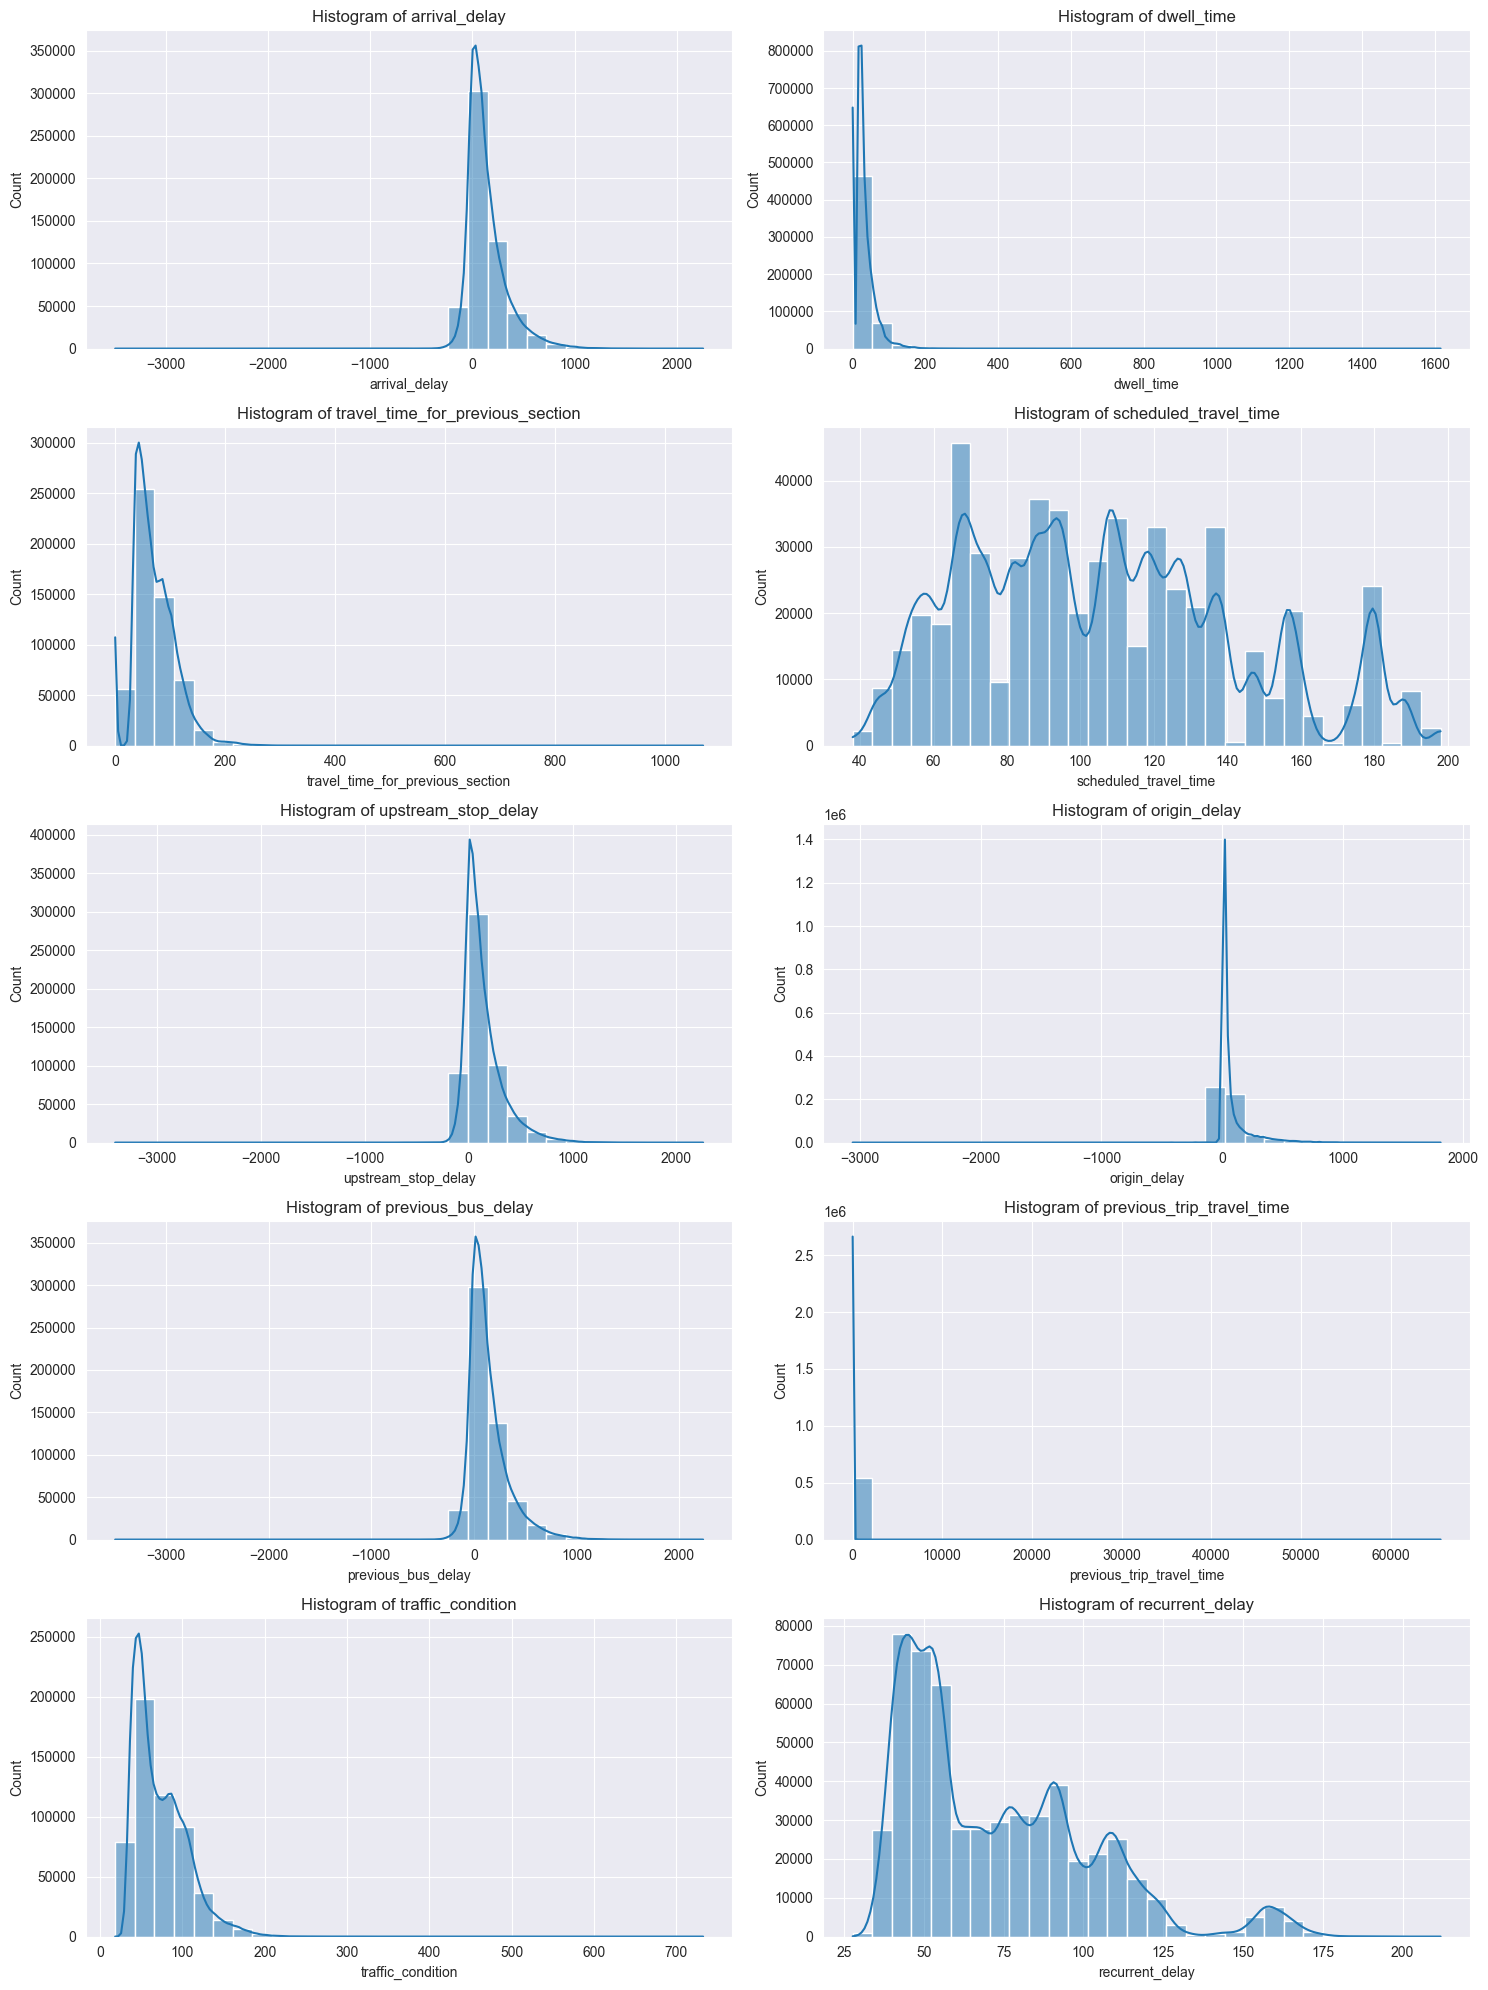

In [91]:
def plot_histogram(df, cols, bins=30):
    rows = (len(cols) + 1) // 2
    plt.figure(figsize=(15, rows * 4))
    for i, col in enumerate(cols, 1):
        plt.subplot(rows, 2, i)
        sns.histplot(df[col], kde=True, bins=bins)
        plt.title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()


numeric_cols = ['arrival_delay', 'dwell_time', 'travel_time_for_previous_section',
                'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay',
                'previous_bus_delay', 'previous_trip_travel_time', 'traffic_condition',
                'recurrent_delay']
plot_histogram(df, numeric_cols)

## Crossed Histograms between Continuous Variables

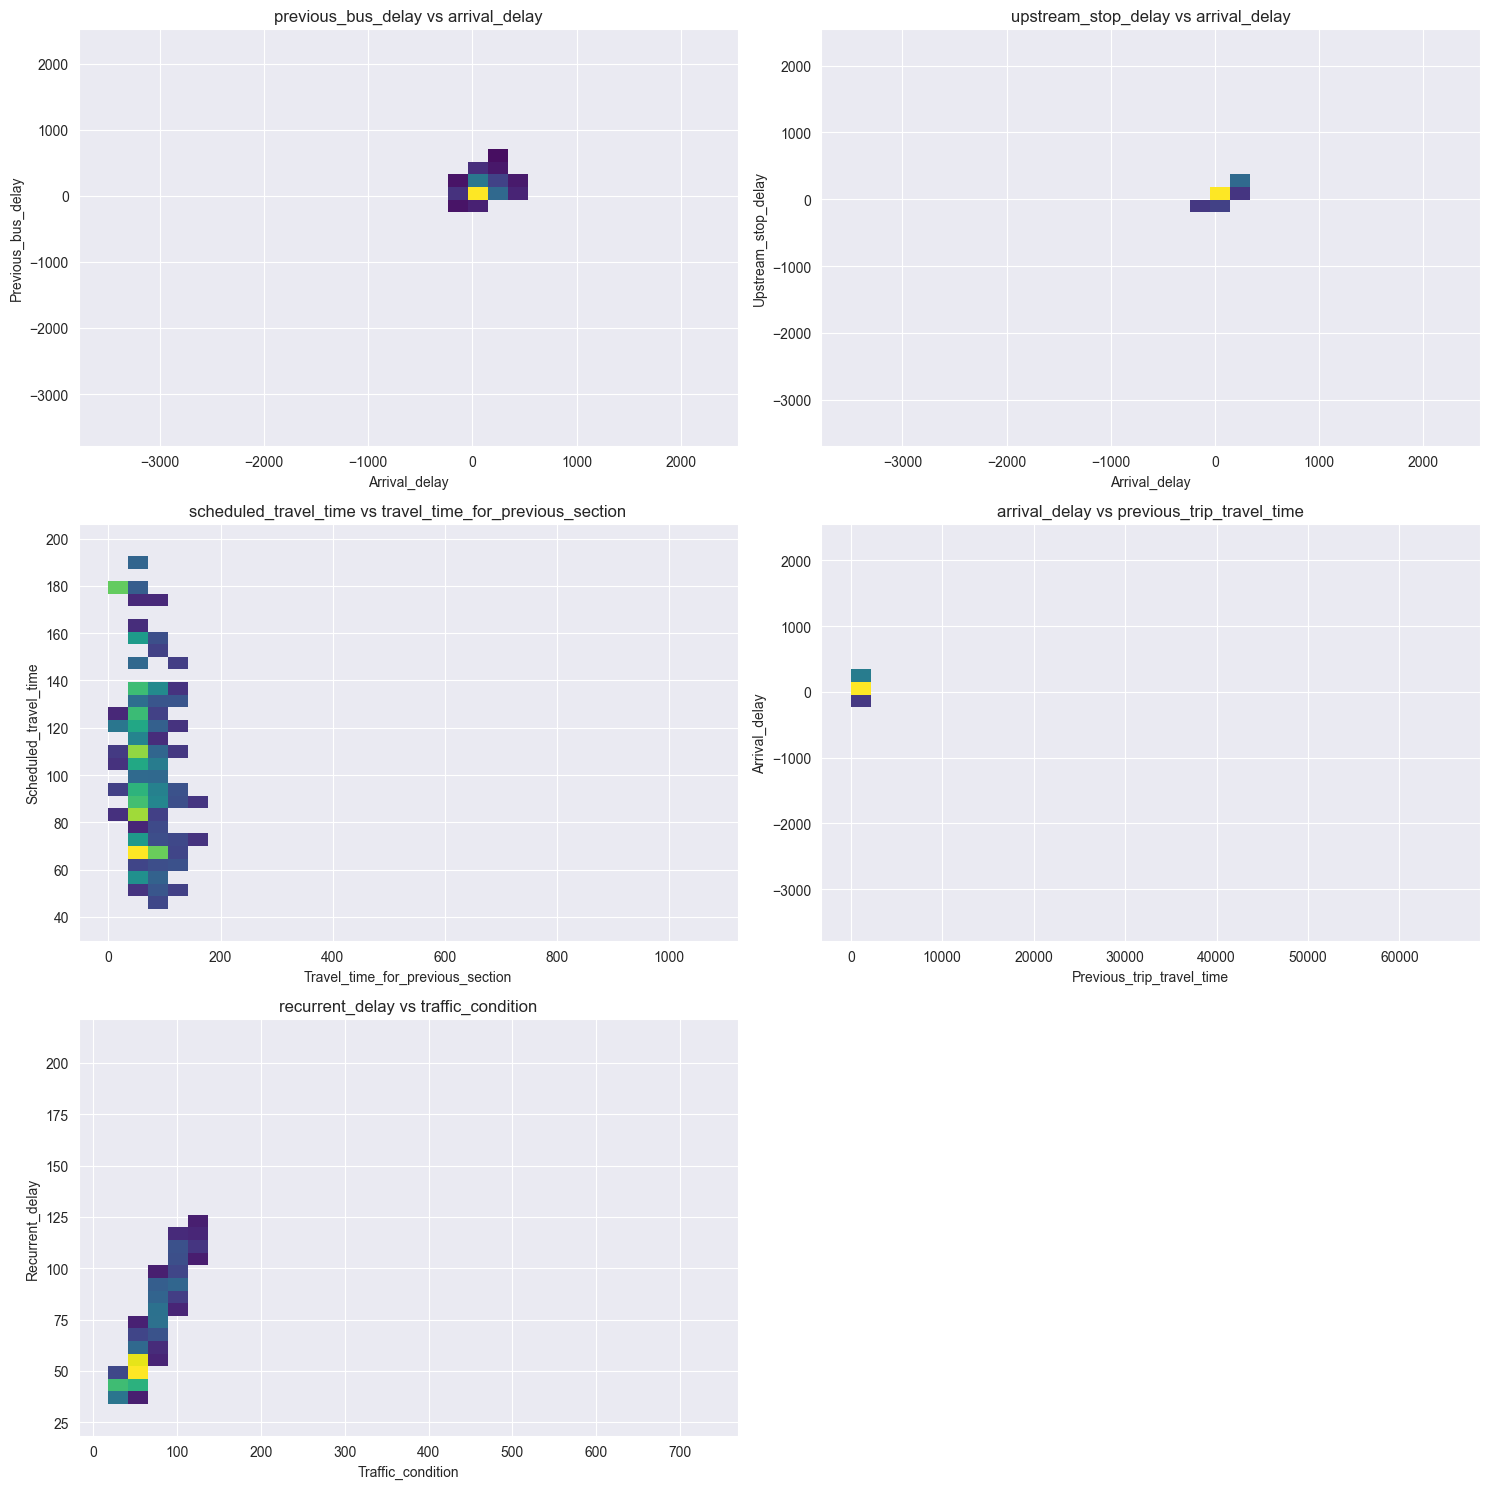

In [92]:
def plot_crossed_histograms_grid(df, pairs, bins=30):
    num_pairs = len(pairs)
    num_cols = 2
    num_rows = (num_pairs + 1) // num_cols

    plt.figure(figsize=(15, num_rows * 5))

    # Plot each pair of continuous variables in a grid
    for i, (col_x, col_y) in enumerate(pairs, 1):
        plt.subplot(num_rows, num_cols, i)

        # Create scatter plot (2D histogram)
        sns.histplot(data=df, x=col_x, y=col_y, bins=bins, pthresh=.1, cmap="viridis")

        # Customize the plot
        plt.title(f'{col_y} vs {col_x}')
        plt.xlabel(col_x.capitalize())
        plt.ylabel(col_y.capitalize())

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()


# Suggest some interesting combinations of continuous variables
continuous_pairs = [
    ('arrival_delay', 'previous_bus_delay'),
    ('arrival_delay', 'upstream_stop_delay'),
    ('travel_time_for_previous_section', 'scheduled_travel_time'),
    ('previous_trip_travel_time', 'arrival_delay'),
    ('traffic_condition', 'recurrent_delay')
]

# Plot crossed combinations of continuous variables in a grid
plot_crossed_histograms_grid(df, continuous_pairs)


## Crossed Histograms between Continuous and Categorical Variables

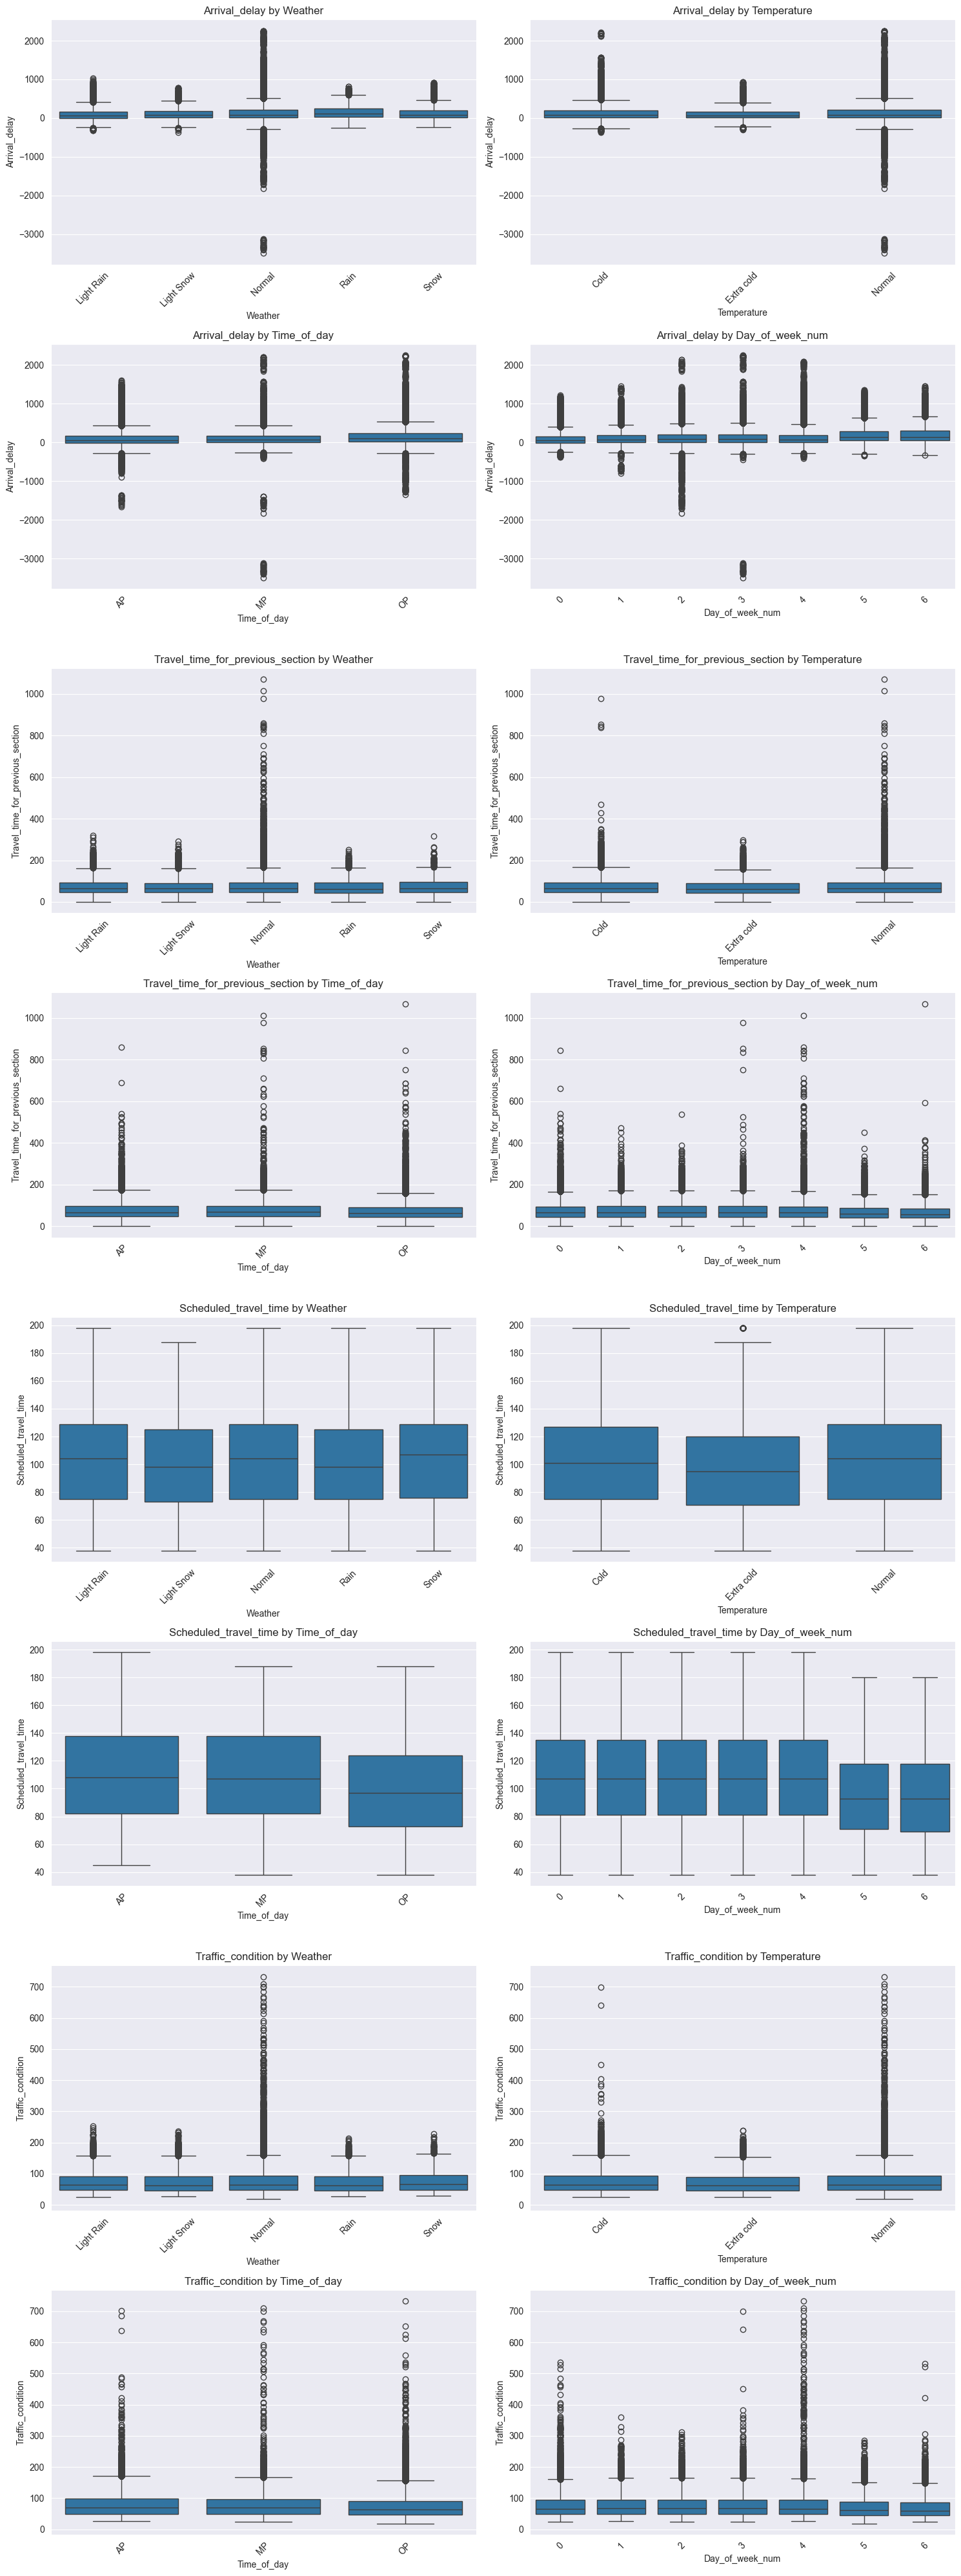

In [93]:
def plot_continuous_vs_categorical_grid(df, continuous_vars, categorical_vars):
    # Calculate the total number of plots and arrange in 2 columns
    num_plots = len(continuous_vars) * len(categorical_vars)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols

    plt.figure(figsize=(15, num_rows * 5))

    # Index for subplot position
    plot_idx = 1

    # Iterate over each combination of continuous and categorical variable
    for col_cont in continuous_vars:
        for col_cat in categorical_vars:
            plt.subplot(num_rows, num_cols, plot_idx)
            plot_idx += 1

            # Create boxplot of the continuous variable by the categorical variable
            sns.boxplot(x=col_cat, y=col_cont, data=df)

            # Customize the plot
            plt.title(f'{col_cont.capitalize()} by {col_cat.capitalize()}')
            plt.xlabel(col_cat.capitalize())
            plt.ylabel(col_cont.capitalize())
            plt.xticks(rotation=45)  # Rotate labels if necessary

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()


# Define continuous and categorical variables to cross
interesting_continuous_vars = ['arrival_delay', 'travel_time_for_previous_section', 'scheduled_travel_time',
                               'traffic_condition']
interesting_categorical_vars = ['weather', 'temperature', 'time_of_day', 'day_of_week_num']

# Plot combinations of continuous and categorical variables in a grid
plot_continuous_vs_categorical_grid(df, interesting_continuous_vars, interesting_categorical_vars)

# Bar Charts
## Bar Charts of Categorical Variables

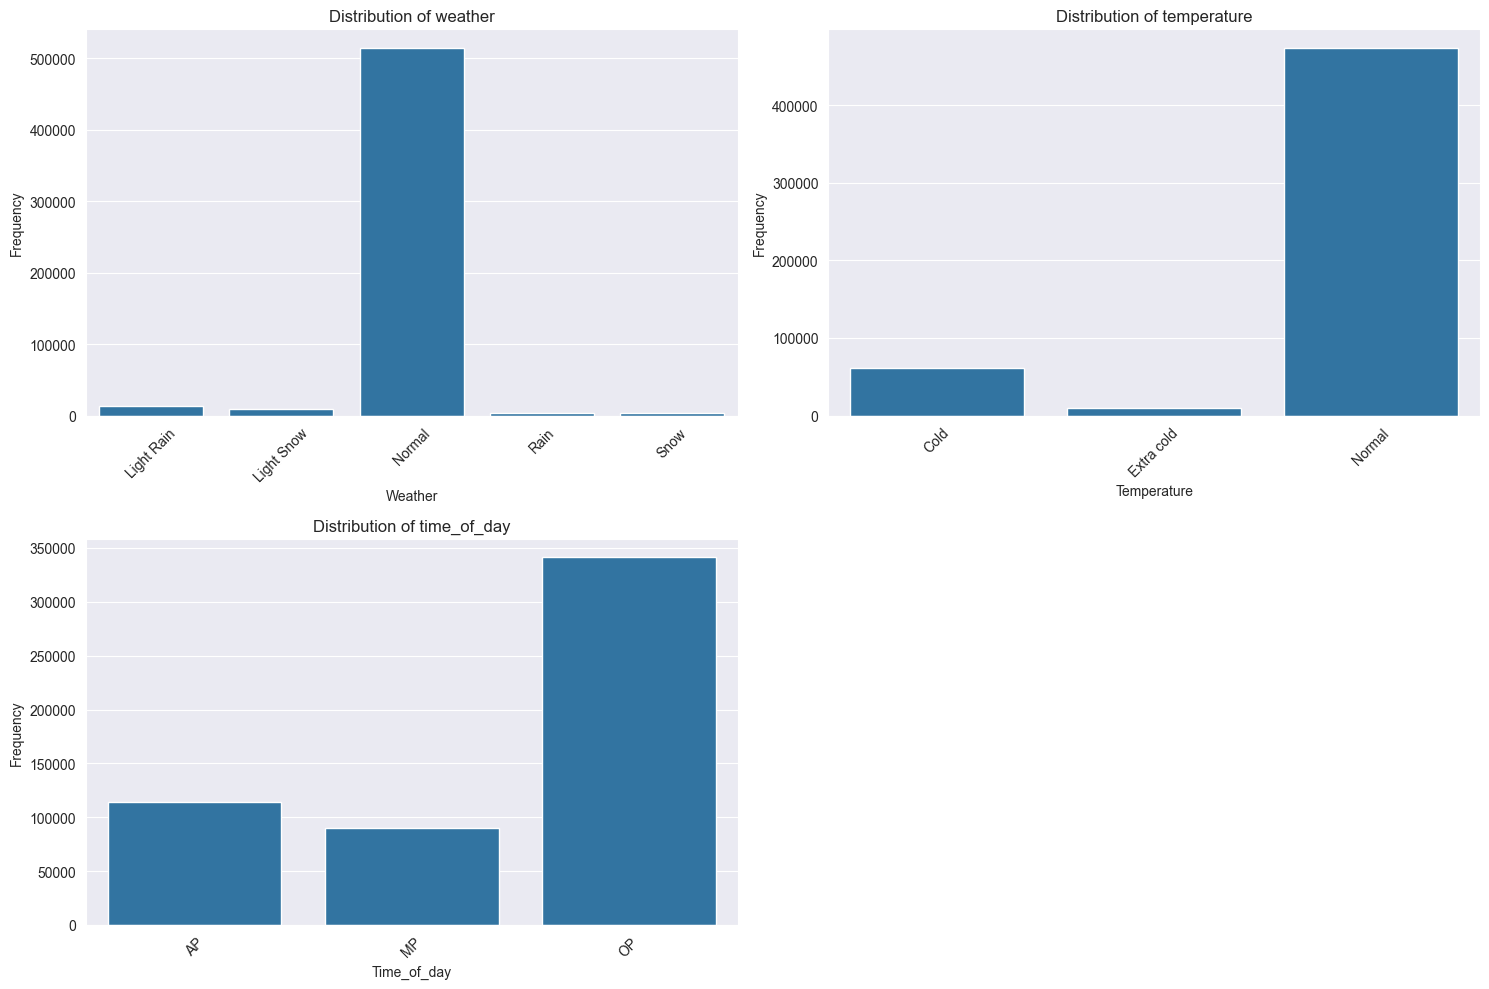

In [94]:
def plot_categorical_bars(df, categorical_cols):
    rows = (len(categorical_cols) + 1) // 2
    plt.figure(figsize=(15, rows * 5))

    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(rows, 2, i)
        # Count the frequency of each category
        value_counts = df[col].value_counts()

        # Create bar plot
        sns.barplot(x=value_counts.index, y=value_counts.values)

        # Customize the plot
        plt.title(f'Distribution of {col}')
        plt.xlabel(col.capitalize())
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)  # Rotate labels if necessary

    plt.tight_layout()
    plt.show()


# Define categorical variables to plot
categorical_vars = ['weather', 'temperature', 'time_of_day']

# Plot frequency distribution of categorical variables
plot_categorical_bars(df, categorical_vars)


# Box Plots
## Box Plots of Continuous Variables

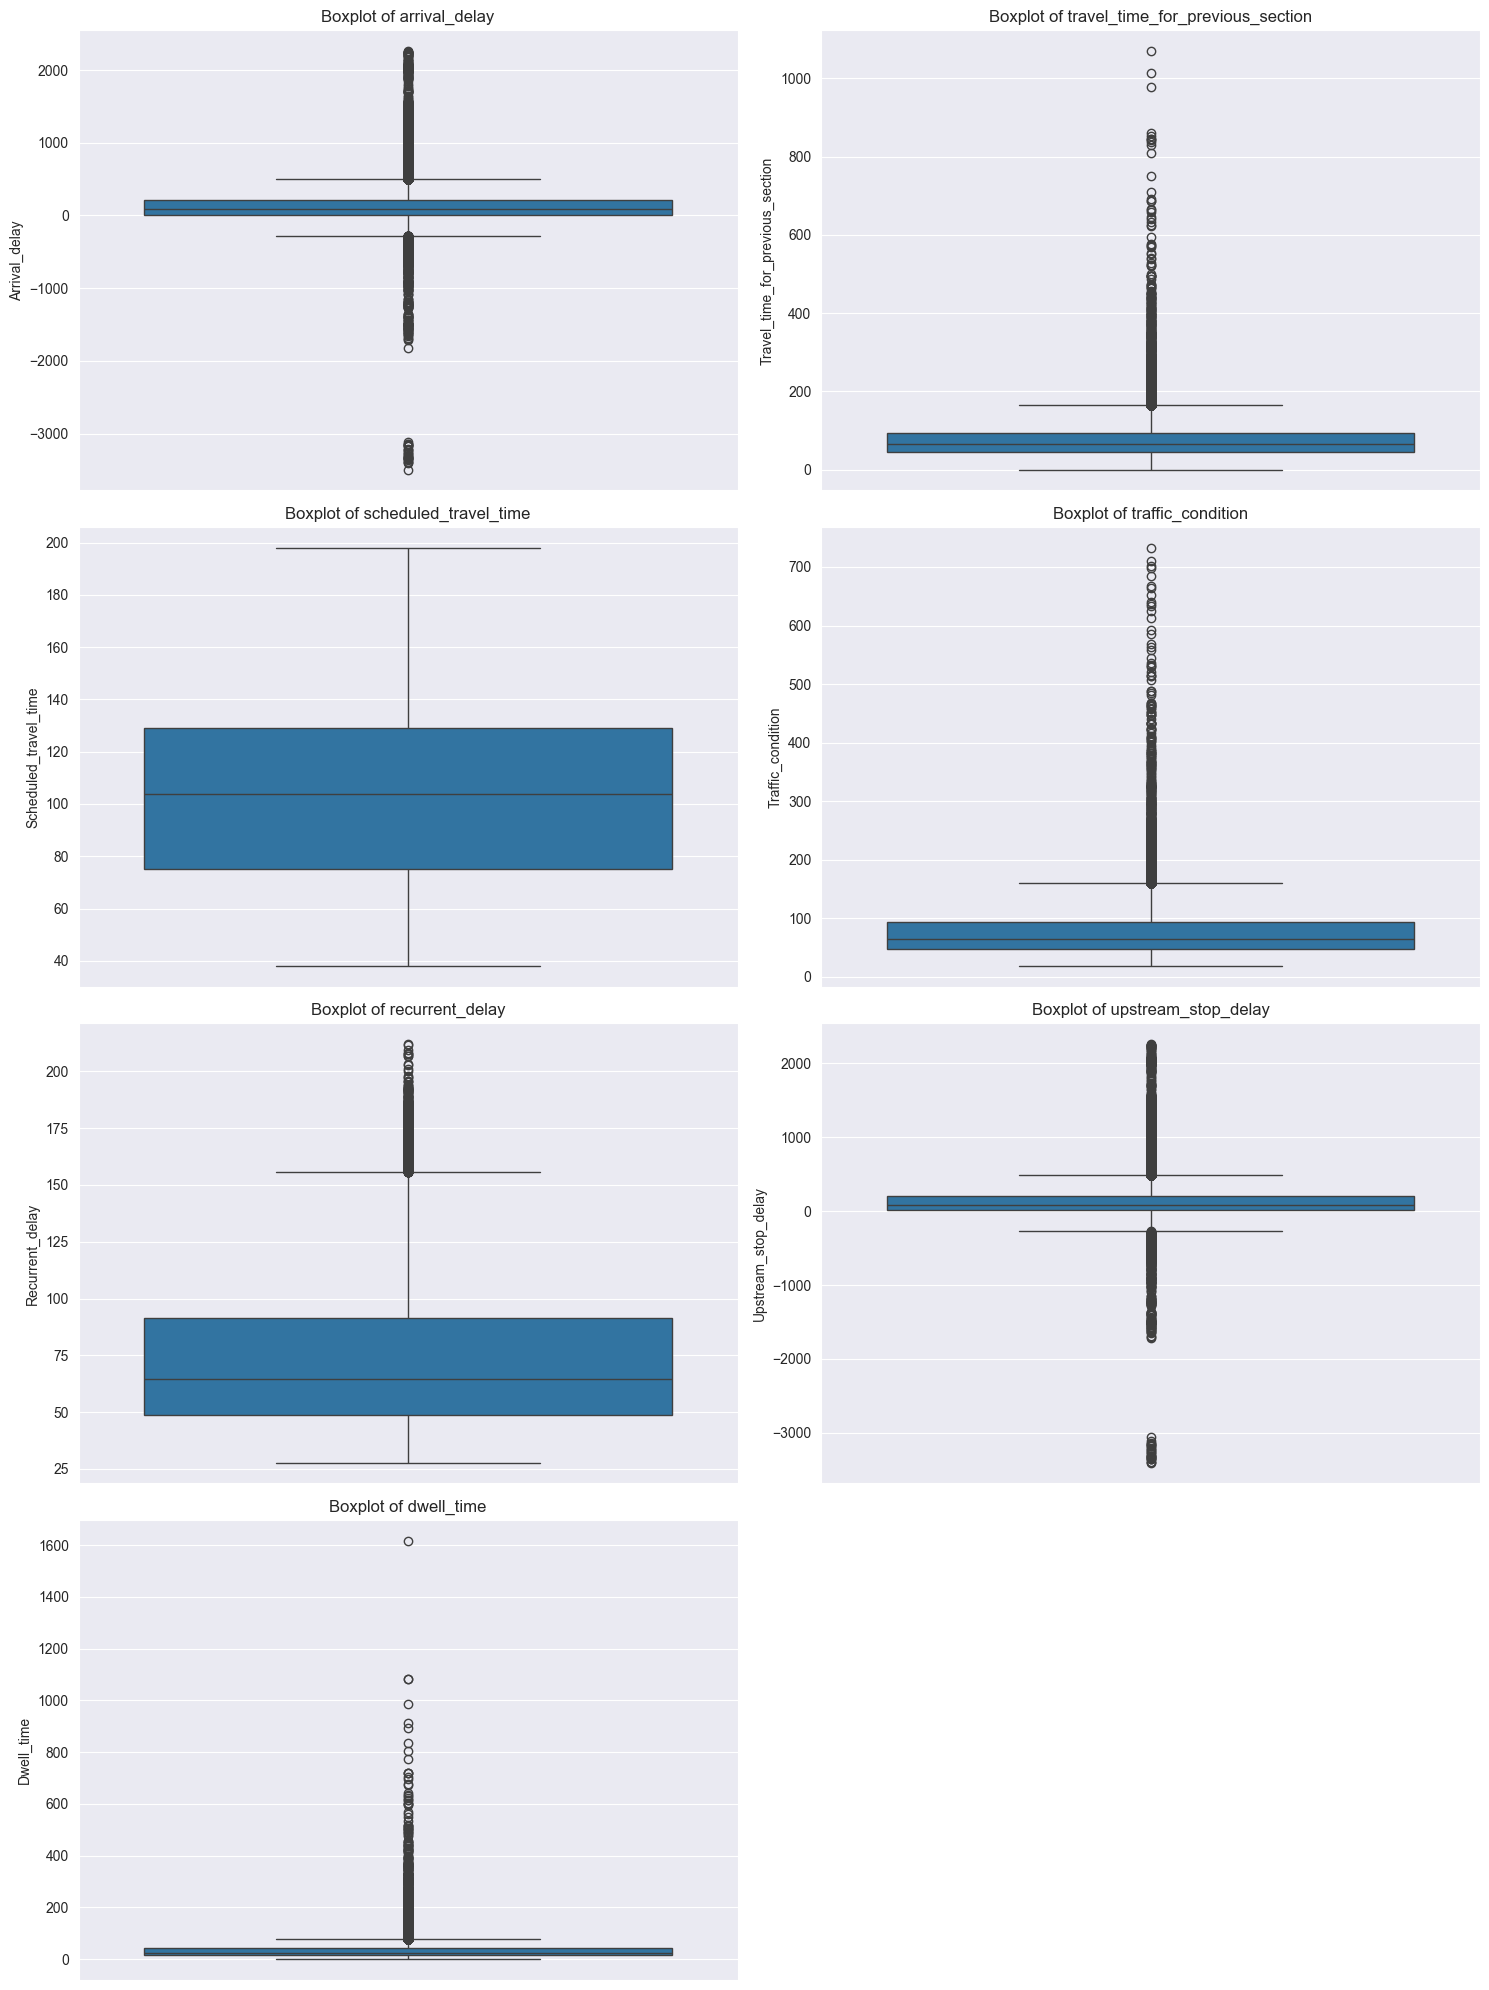

In [95]:
def plot_boxplots_continuous(df, continuous_vars):
    # Calculate the total number of variables and arrange in 2 columns
    num_vars = len(continuous_vars)
    num_cols = 2
    num_rows = (num_vars + 1) // num_cols

    plt.figure(figsize=(15, num_rows * 5))

    # Plot each continuous variable
    for i, col in enumerate(continuous_vars, 1):
        plt.subplot(num_rows, num_cols, i)

        # Create boxplot of the continuous variable
        sns.boxplot(data=df, y=col)

        # Customize the plot
        plt.title(f'Boxplot of {col}')
        plt.ylabel(col.capitalize())

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()


# Define continuous variables to plot
continuous_vars = ['arrival_delay', 'travel_time_for_previous_section', 'scheduled_travel_time',
                   'traffic_condition', 'recurrent_delay', 'upstream_stop_delay', 'dwell_time']

# Plot boxplots of the continuous variables
plot_boxplots_continuous(df, continuous_vars)

# Outliers

In [96]:
from scipy import stats


def remove_multiple_outliers(df, cols, threshold=3):
    initial_rows = df.shape[0]  # Initial number of rows
    total_removed = pd.Series(0, index=cols)  # Series to count rows removed per column

    # Iterate over each column and remove outliers
    for col in cols:
        z_scores = stats.zscore(df[col])
        abs_z_scores = np.abs(z_scores)
        is_not_outlier = abs_z_scores <= threshold

        # Count removed rows
        total_removed[col] = initial_rows - is_not_outlier.sum()

        # Filter the DataFrame for the current column
        df = df[is_not_outlier]

    # Calculate the total number of rows after removing outliers
    final_rows = df.shape[0]
    total_removed_absolute = initial_rows - final_rows

    # Calculate removal percentages
    removal_percentage = (total_removed / initial_rows) * 100
    total_removal_percentage = (total_removed_absolute / initial_rows) * 100

    # Print removal statistics per column
    print("\n### Outlier Removal Statistics ###\n")
    print(f"Initial number of rows: {initial_rows}")
    print(f"Final number of rows: {final_rows}")
    print(f"Total rows removed: {total_removed_absolute} ({total_removal_percentage:.2f}%)")
    print("\nRows removed per column:")
    for col in cols:
        print(f" - {col}: {total_removed[col]} removed ({removal_percentage[col]:.2f}%)")

    return df


# Define continuous variables for which to remove outliers
'''
continuous_vars = ['arrival_delay', 'travel_time_for_previous_section', 'scheduled_travel_time',
                   'traffic_condition', 'recurrent_delay', 'upstream_stop_delay', 'dwell_time']
'''
continuous_vars = ['arrival_delay', 'dwell_time']

# Remove outliers from multiple columns
df_cleaned_multiple = remove_multiple_outliers(df, continuous_vars)
# Export the cleaned DataFrame as a CSV file
output_path = "data/no_sample.csv"
df_cleaned_multiple.to_csv(output_path, index=False)

print(f"The DataFrame has been successfully exported to {output_path}")


### Outlier Removal Statistics ###

Initial number of rows: 545103
Final number of rows: 525632
Total rows removed: 19471 (3.57%)

Rows removed per column:
 - arrival_delay: 9447 removed (1.73%)
 - dwell_time: 19471 removed (3.57%)
The DataFrame has been successfully exported to data/no_sample.csv


In [97]:
# Sub Sampling
## Stratified Sampling
df_sorted = df_cleaned_multiple.sort_values('Calendar_date')
df_time_sampled = df_sorted.iloc[::10, :].reset_index(drop=True)

df_train, df_stratified = train_test_split(
    df_time_sampled,
    test_size=0.1,
    stratify=df_time_sampled['day_of_week'],
    random_state=42
)
# Export the cleaned DataFrame as a CSV file
output_path = "data/stratified.csv"
df_stratified.to_csv(output_path, index=False)

print(f"The DataFrame has been successfully exported to {output_path}")

The DataFrame has been successfully exported to data/stratified.csv


## KMeans Sampling

In [98]:
from sklearn.cluster import KMeans


def kmeans_subsampling(df, columns_to_exclude, n_clusters=10, sample_percentage=0.01):
    # Exclude specific columns
    df_filtered = df.drop(columns=columns_to_exclude)

    # Separate features (X) and target variable (y)
    X = df_filtered.drop(['arrival_delay'], axis=1)
    y = df_filtered['arrival_delay']

    # Determine the total number of rows to calculate sample size per cluster
    total_rows = X.shape[0]

    # Calculate the number of samples per cluster as 1% of the total rows
    samples_per_cluster = int(sample_percentage * total_rows / n_clusters)

    # Apply KMeans clustering using the filtered columns
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    df['cluster'] = clusters

    # Sample a percentage from each cluster, allowing replacement if necessary
    df_kmeans_sampled = df.groupby('cluster', group_keys=False).apply(
        lambda x: x.sample(
            n=samples_per_cluster,  # Always take the calculated size
            replace=True,  # Allow replacement if there are fewer rows in the cluster
            random_state=42
        )
    ).reset_index(drop=True)

    return df_kmeans_sampled


# Define columns to exclude for KMeans
columns_to_drop = ['Calendar_date', 'route_id', 'bus_id', 'weather', 'temperature', 'day_of_week', 'time_of_day']

# Apply KMeans for sampling based on 1% of total rows
df_kmeans_sampled = kmeans_subsampling(df_cleaned_multiple, columns_to_drop)
df_kmeans_sampled = df_kmeans_sampled.drop(columns=['cluster'])
# Export the cleaned DataFrame as a CSV file
output_path = "data/KMeans.csv"
df_kmeans_sampled.to_csv(output_path, index=False)

print(f"The DataFrame has been successfully exported to {output_path}")

The DataFrame has been successfully exported to data/KMeans.csv


C:\Users\jecla\AppData\Local\Temp\ipykernel_105648\3946067369.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_kmeans_sampled = df.groupby('cluster', group_keys=False).apply(


# Plots Original vs. KMeans Distribution

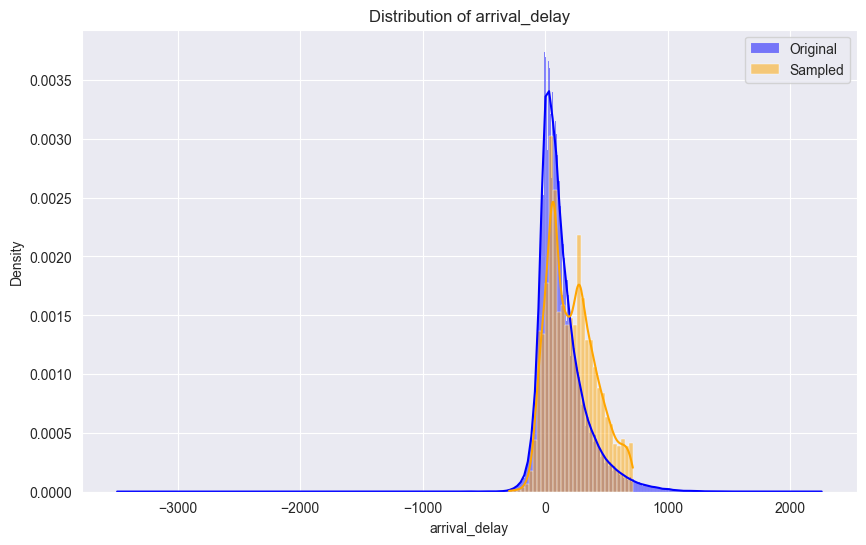

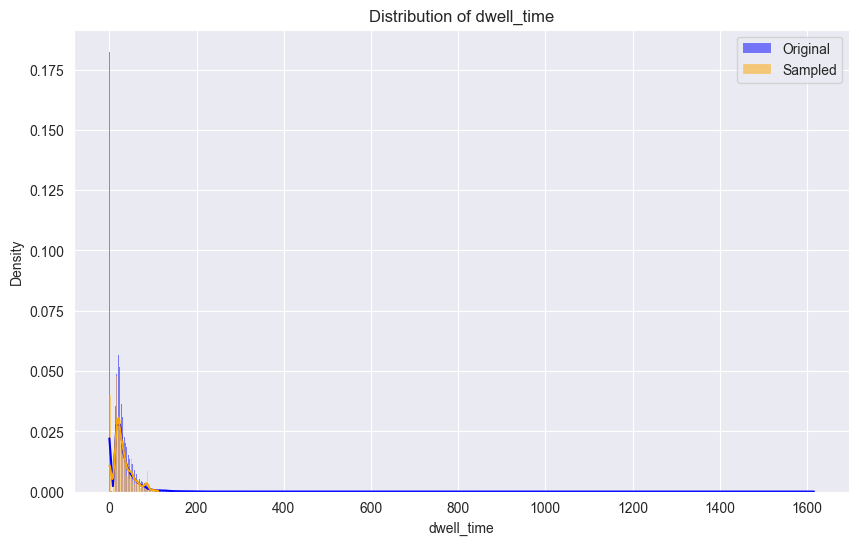

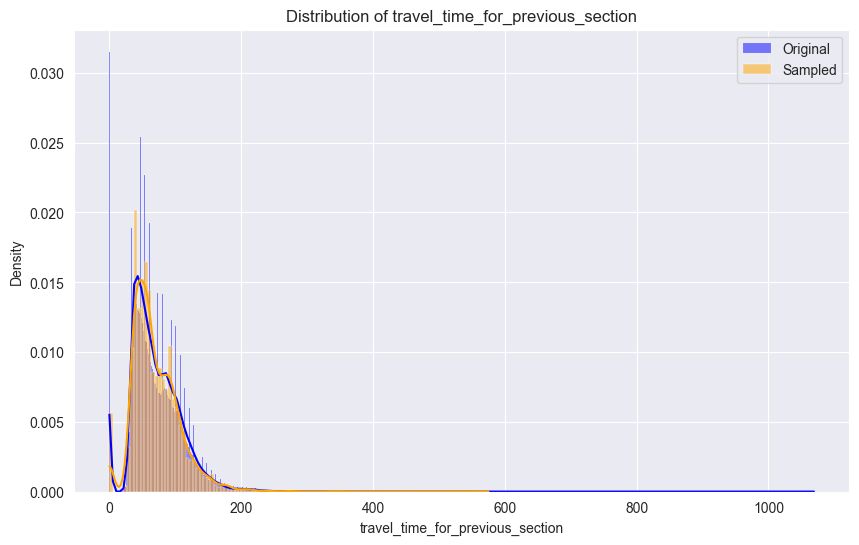

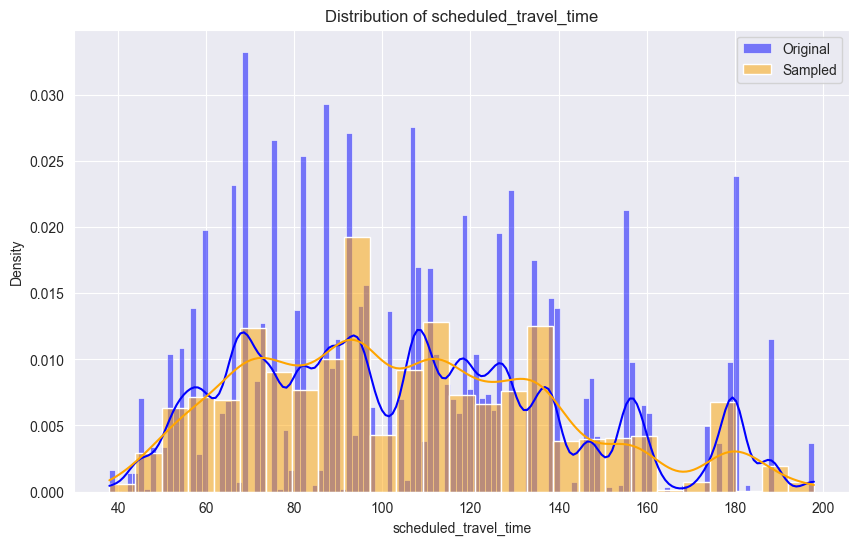

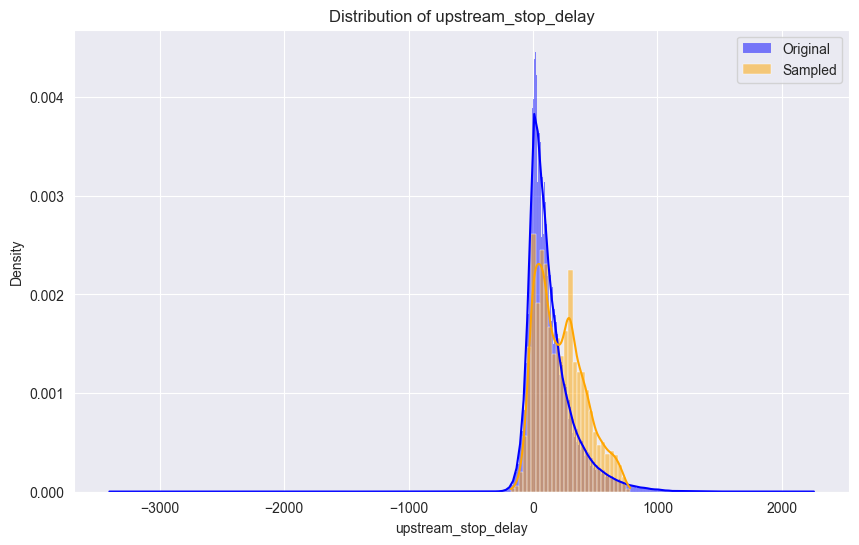

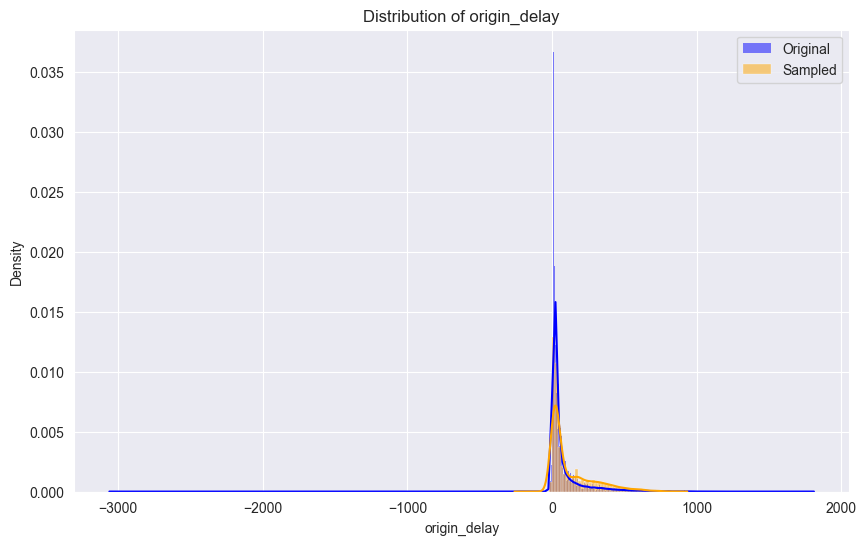

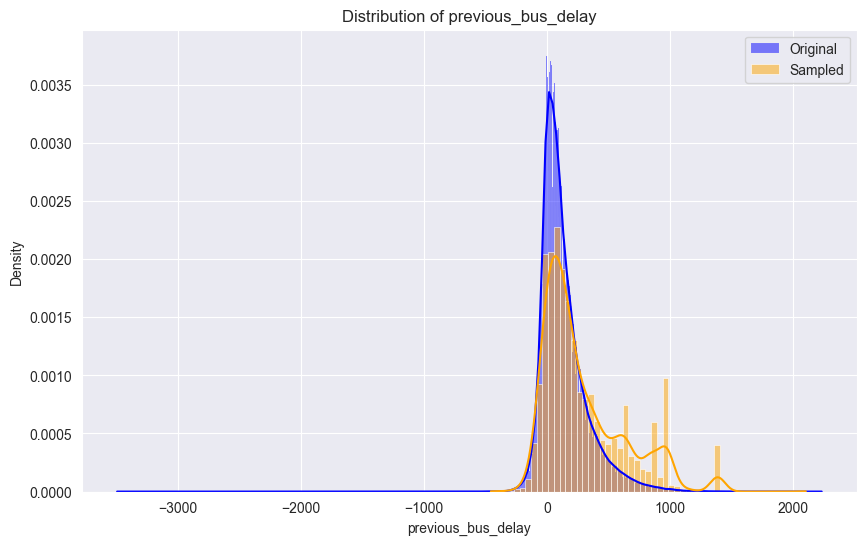

C:\Users\jecla\Documents\PT_AI_Proyect\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


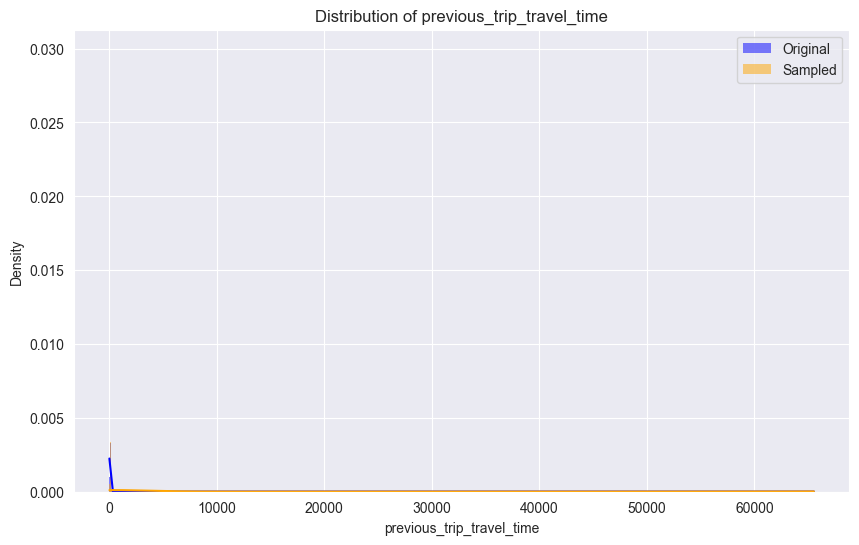

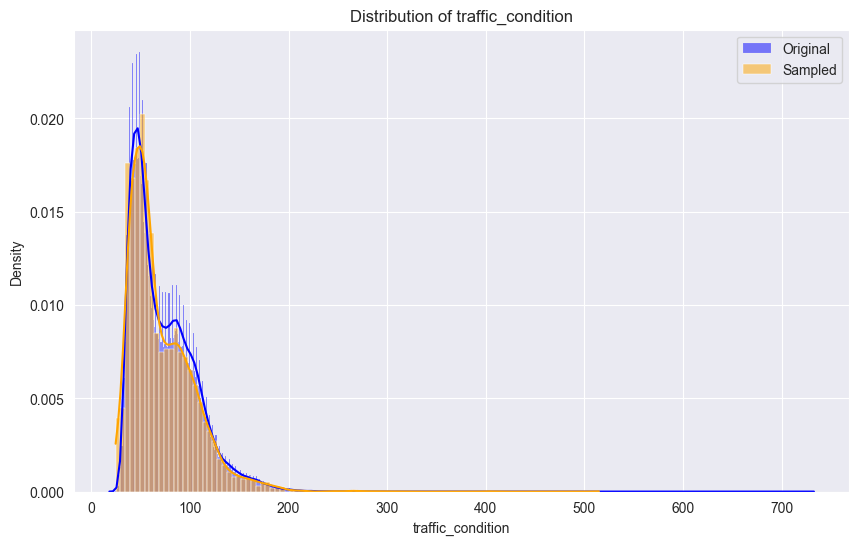

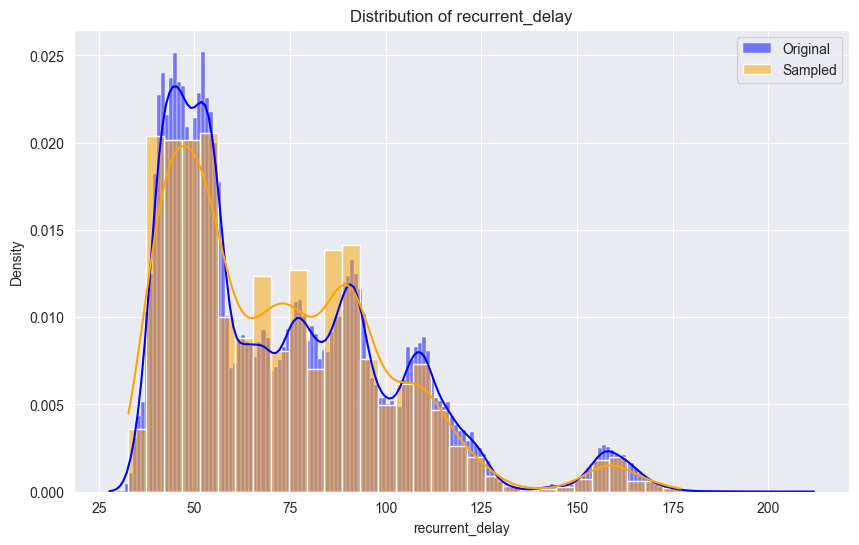

In [99]:
def plot_distributions(df_original, df_sampled, cols):
    for col in cols:
        plt.figure(figsize=(10, 6))
        sns.histplot(df_original[col], color='blue', label='Original', kde=True, stat="density")
        sns.histplot(df_sampled[col], color='orange', label='Sampled', kde=True, stat="density")
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.show()


plot_distributions(df, df_kmeans_sampled, numeric_cols)


# Statistical Comparisons
## Statistical Comparison

In [100]:
def compare_statistics(df_original, df_sampled, numeric_cols, threshold=0.05):
    original_summary = df_original[numeric_cols].describe()
    sampled_summary = df_sampled[numeric_cols].describe()

    print("\n### Statistics Comparison ###")
    for col in numeric_cols:
        mean_diff = np.abs(original_summary.loc['mean', col] - sampled_summary.loc['mean', col]) / original_summary.loc[
            'mean', col]
        print(f"{col} - Mean Difference: {mean_diff:.2%} (Threshold: {threshold * 100}%)")

        # Other comparisons of medians and standard deviations can be added here


compare_statistics(df, df_stratified, numeric_cols)
compare_statistics(df, df_kmeans_sampled, numeric_cols)


### Statistics Comparison ###
arrival_delay - Mean Difference: 8.75% (Threshold: 5.0%)
dwell_time - Mean Difference: 6.56% (Threshold: 5.0%)
travel_time_for_previous_section - Mean Difference: 1.22% (Threshold: 5.0%)
scheduled_travel_time - Mean Difference: 0.72% (Threshold: 5.0%)
upstream_stop_delay - Mean Difference: 7.24% (Threshold: 5.0%)
origin_delay - Mean Difference: 9.65% (Threshold: 5.0%)
previous_bus_delay - Mean Difference: 1.85% (Threshold: 5.0%)
previous_trip_travel_time - Mean Difference: 1.55% (Threshold: 5.0%)
traffic_condition - Mean Difference: 0.72% (Threshold: 5.0%)
recurrent_delay - Mean Difference: 0.56% (Threshold: 5.0%)

### Statistics Comparison ###
arrival_delay - Mean Difference: 61.85% (Threshold: 5.0%)
dwell_time - Mean Difference: 4.36% (Threshold: 5.0%)
travel_time_for_previous_section - Mean Difference: 1.57% (Threshold: 5.0%)
scheduled_travel_time - Mean Difference: 0.94% (Threshold: 5.0%)
upstream_stop_delay - Mean Difference: 62.83% (Threshold: 5.0%)

## T-test

In [101]:
def perform_t_test(df_original, df_sampled, cols, alpha=0.05):
    print("\n### T-tests ###")
    for col in cols:
        t_stat, p_value = ttest_ind(df_original[col], df_sampled[col])
        result = "Significant" if p_value < alpha else "Not Significant"
        print(f"{col} - p-value: {p_value:.3f} ({result})")


perform_t_test(df, df_stratified, numeric_cols)
perform_t_test(df, df_kmeans_sampled, numeric_cols)



### T-tests ###
arrival_delay - p-value: 0.000 (Significant)
dwell_time - p-value: 0.000 (Significant)
travel_time_for_previous_section - p-value: 0.094 (Not Significant)
scheduled_travel_time - p-value: 0.129 (Not Significant)
upstream_stop_delay - p-value: 0.000 (Significant)
origin_delay - p-value: 0.000 (Significant)
previous_bus_delay - p-value: 0.354 (Not Significant)
previous_trip_travel_time - p-value: 0.680 (Not Significant)
traffic_condition - p-value: 0.243 (Not Significant)
recurrent_delay - p-value: 0.322 (Not Significant)

### T-tests ###
arrival_delay - p-value: 0.000 (Significant)
dwell_time - p-value: 0.000 (Significant)
travel_time_for_previous_section - p-value: 0.032 (Significant)
scheduled_travel_time - p-value: 0.049 (Significant)
upstream_stop_delay - p-value: 0.000 (Significant)
origin_delay - p-value: 0.000 (Significant)
previous_bus_delay - p-value: 0.000 (Significant)
previous_trip_travel_time - p-value: 0.000 (Significant)
traffic_condition - p-value: 0.000

## Chi-square

In [102]:
def perform_chi_square_test(df_original, df_sampled, dummy_vars, alpha=0.05):
    print("\n### Chi-Square Tests ###")
    for var in dummy_vars:
        contingency_table = pd.crosstab(df_original[var], df_sampled[var])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        result = "Significant" if p_value < alpha else "Not Significant"
        print(f"{var} - p-value: {p_value:.3f} ({result})")


perform_chi_square_test(df, df_stratified, dummy_vars)
perform_chi_square_test(df, df_kmeans_sampled, dummy_vars)


### Chi-Square Tests ###
factor(weather)Light_Rain - p-value: 0.301 (Not Significant)
factor(weather)Light_Snow - p-value: 0.677 (Not Significant)
factor(weather)Normal - p-value: 0.064 (Not Significant)
factor(weather)Rain - p-value: 1.000 (Not Significant)
factor(weather)Snow - p-value: 1.000 (Not Significant)
factor(temperature)Cold - p-value: 0.001 (Significant)
factor(temperature)Extra_cold - p-value: 0.347 (Not Significant)
factor(temperature)Normal - p-value: 0.000 (Significant)
factor(day_of_week)weekday - p-value: 0.000 (Significant)
factor(day_of_week)weekend - p-value: 0.000 (Significant)
factor(time_of_day)Afternoon_peak - p-value: 0.119 (Not Significant)
factor(time_of_day)Morning_peak - p-value: 0.593 (Not Significant)
factor(time_of_day)Off-peak - p-value: 0.000 (Significant)

### Chi-Square Tests ###
factor(weather)Light_Rain - p-value: 1.000 (Not Significant)
factor(weather)Light_Snow - p-value: 0.311 (Not Significant)
factor(weather)Normal - p-value: 0.663 (Not Signi